In [1]:
import anndata as ad
import os, re
import numpy as np
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") 

import scipy.sparse as sparse
from scipy.io import mmread
from scipy.stats import pearsonr, pointbiserialr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import seaborn as sns
import scanpy as sc
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 1 # errors (0), warnings (1), info (2), hints (3)
plt.rcParams["font.family"] = "Arial"
sns.set_style("white")

import random
# Note that BANKSY itself is deterministic, here the seeds affect the umap clusters and leiden partition
seed = 1234
np.random.seed(seed)
random.seed(seed)

scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.11.2 pynndescent==0.5.10


## Load Xenium data
Allocate path to folder and the file name of the designated AnnaData Object (in `.h5ad` format) <br>

In [2]:
adata = ad.read_h5ad("data/xenium/raw_data/CK_skin_res.h5ad")
output_path = "data/xenium/processed/CK_skin_res.h5ad"
adata.obs_keys()

import numpy as np
adata.obsm['xy'] = np.vstack([adata.obs['x'], adata.obs['y']]).T

adata.write(output_path)

In [3]:
# adata.obsm_keys()

In [4]:
# check the float size of the adata.obsm data
for key in adata.obsm.keys():
    arr = adata.obsm[key]
    if isinstance(arr, np.ndarray):
        print(f"{key}: shape={arr.shape}, dtype={arr.dtype}")

xy: shape=(6760, 2), dtype=float64


In [5]:
#downcast adata.obsm to 32 bit and test if that is compatible with the rest of the workflow
for key in adata.obsm.keys():
    arr = adata.obsm[key]
    if isinstance(arr, np.ndarray) and np.issubdtype(arr.dtype, np.floating): #check if the array is an N-dimensional array
        adata.obsm[key] = arr.astype(np.float32)


In [6]:
# check the float size of the adata.obsm data
for key in adata.obsm.keys():
    arr = adata.obsm[key]
    if isinstance(arr, np.ndarray):
        print(f"{key}: shape={arr.shape}, dtype={arr.dtype}")

xy: shape=(6760, 2), dtype=float32


In [7]:
import anndata as ad
adata.write_h5ad(
    filename = "data/xenium/processed/CK_skin_res_float_32.h5ad",
    compression="gzip"
    )

In [8]:
# Define File paths
#file_path = os.path.join("data", "slide_seq", "v1")
#gcm_filename = "Cerebellum_MappedDGEForR.csv"

# (Optional) Arguments for load_data only if annadata is not present
#locations_filename = "Cerebellum_BeadLocationsForR.csv"
file_path = os.path.join("data", "xenium", "processed")
adata_filename = "CK_skin_res.h5ad"

In [9]:
print(f"Looking for {os.path.join(file_path, adata_filename)}")
print(type(file_path)) 
print(type(adata_filename))

Looking for data/xenium/processed/CK_skin_res.h5ad
<class 'str'>
<class 'str'>


### Loading anndata file or converting raw files to anndata format  (h5ad)

- If the specified anndata file is present in the directory, the annadata file `.h5ad` in the file path can be read directly by setting the `load_adata_directly` to `True` <br>
- Otherwise, if the `AnnData` file is not present, `load_data` can convert the raw data of GCM and locations in `.csv` format to `.h5ad` directly.

In [10]:
from banksy_utils.load_data import load_adata, display_adata

# To either load data from .h5ad directly or convert raw data to .h5ad format
load_adata_directly = True

# Keys to specify coordinate indexes in the anndata Object
coord_keys = ('x', 'y', 'xy')

raw_y, raw_x, adata = load_adata(filepath=file_path, adata_filename=adata_filename, load_adata_directly=True, coord_keys=('x','y','xy'))

Looking for data/xenium/processed/CK_skin_res.h5ad
Attemping to read Annadata directly
Anndata file successfully loaded!
Attempting to concatenate spatial x-y under adata.obsm[xy]
Concatenation success!


In [11]:
import inspect
from banksy_utils.load_data import load_adata

# Inspect the function signature to understand expected arguments
print(inspect.signature(load_adata))


(filepath: str, load_adata_directly: bool, adata_filename: str, gcm_filename: str = '', locations_filename: str = '', coord_keys: Tuple[str] = ('xcoord', 'ycoord', 'xy_coord')) -> anndata._core.anndata.AnnData


### Display Anndata Object
Use `display_adata` to show summary of anndata object

In [ ]:
# display_adata(adata)

### Preprocessing the Data using `Scanpy` 
We then preprocess the raw data as follows:

1. Making variable names unique (removing duplicate gene names)
2. Filtering out the mitochondria genes (`MT`)
3. We use `scanpy`'s built-in function `sc.pp.calculate_qc_metrics` and adding them in-place in the anndata object

In [ ]:
# adata.var_names_make_unique()
# adata.var["mt"] = adata.var_names.str.startswith("MT-")

# # Calulates QC metrics and put them in place to the adata object
# sc.pp.calculate_qc_metrics(adata, 
#                            qc_vars=["mt"], 
#                            log1p=True, 
#                            inplace=True)

### Get preview of the preprocessed data: 
Display the qc-metrics under its observations and variables 

In [ ]:
# display(adata.obs, adata.var)

## Visualize the histogram plot of `total_counts` and `n_genes` (Optional)
We can visualize the unfiltered and filtered histograms for `total_counts` and `n_genes` variables in the adata object <br> 

The filtered histograms are plotted after filtering by the upper threshold of total counts `total_counts_cuttoff`, the upper threshold of n_genes `n_genes_high_cutoff`, and the lower threshold of n_genes

In [ ]:
# display_adata(adata)

In [12]:
from banksy_utils.plot_utils import plot_qc_hist, plot_cell_positions

# # bin options for fomratting histograms
# # Here, we set 'auto' for 1st figure, 80 bins for 2nd figure. and so on
# hist_bin_options = ['auto', 80, 80, 100]

# plot_qc_hist(adata, 
#          total_counts_cutoff = 300, # for visualization
#          n_genes_high_cutoff = 1000, # for visualization
#          n_genes_low_cutoff = 0, # for visualization
#          bin_options = hist_bin_options)

## Do an initial filter of cells by their cell counts, MT count and gene counts
### We can then first filter cells by their counts, MT and gene filters.

In [ ]:
# from banksy_utils.filter_utils import filter_cells

# # Filter cells with each respective filters
# adata = filter_cells(adata, 
#              min_count=10, 
#              max_count=1000, 
#              MT_filter=20, 
#              gene_filter=10)

### Show summary of data after filtering by cell counts and MT

In [ ]:
#display_adata(adata)

### Plot the Histograms of the filtered dataset

In [ ]:
# hist_bin_options = ['auto', 100, 60, 100]

# plot_qc_hist(adata,
#         total_counts_cutoff=2000,
#         n_genes_high_cutoff=2000, 
#         n_genes_low_cutoff= 0,
#         bin_options = hist_bin_options)

### Visualize the position of cells using a scatter plot
For `slideseq_v2`, we customize the plot with a puck_center 

{'fig_size': (6, 6), 's': 0.2, 'c1': 'red', 'c2': 'slateblue', 'label1': 'Original cells', 'label2': 'Remaining cells', 'add_circle': False, 'puck_center': (3330, 3180), 'puck_radius': 2550}


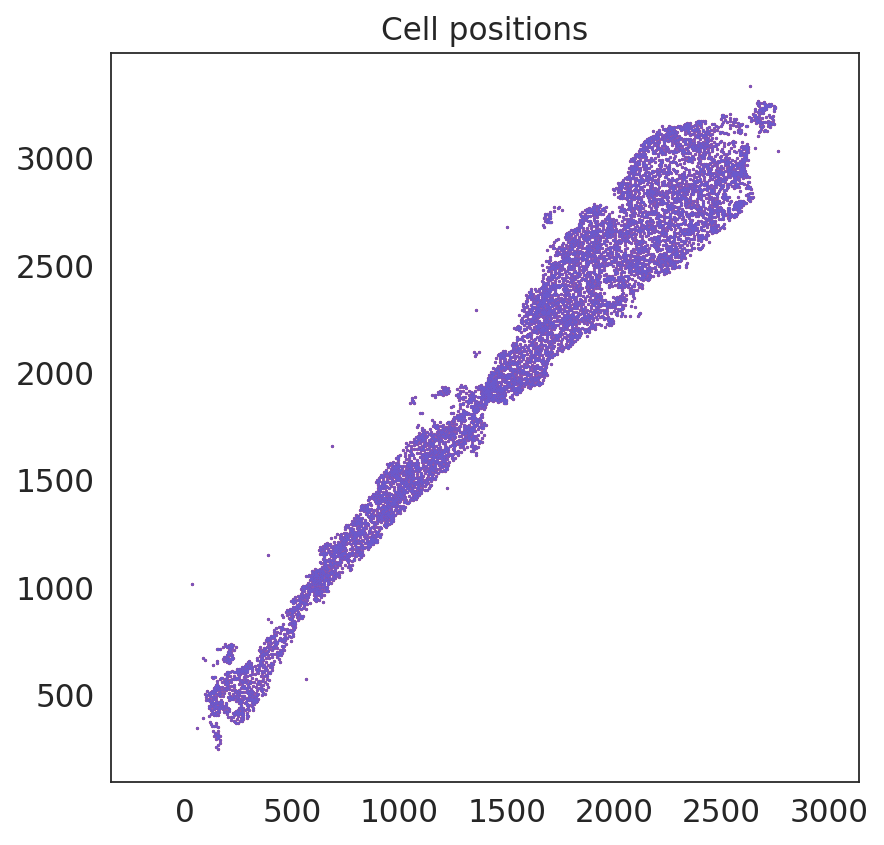

In [13]:
# Visualize cell positions in puck
plot_cell_positions(adata,
            raw_x,
            raw_y,
            coord_keys=coord_keys,
            fig_size = (6,6))

## Normalize & Filter highly variable genes (HVG)

### Normalize data matrix using `normalize_total`


In [ ]:
# from banksy_utils.filter_utils import normalize_total, filter_hvg, print_max_min

# # Normalizes the anndata dataset
# adata = normalize_total(adata)

### Filter by Highly Variable Genes (HVG) using a specified threshold

We use the **raw count data** (flavor = `"seurat_v3"`) or **log-transformed data** (flavor = `"seurat"`). Here, we recommend using the default `seurat` flavor from `Scanpy`.

Here we keep the original AnnData object (`adata_allgenes`) for the analysis of the results produced by BANKSY if nessecary. However, we will mostly be running banksy with the filtered AnnData object (`adata`)

In [ ]:
# adata, adata_allgenes = filter_hvg(adata,
#             n_top_genes = 2000,
#             flavor="seurat")

### Check genes and cells annotations

Display attribute of the filtered data after filtering steps and HVG analysis

In [ ]:
#display_adata(adata)

## Generate spatial weights graph

#### In BANKSY, we imagine edges / connections in the graph to represent neighbour relationships between cells

In doing so, the banksy algorithm requires the following specifications in the main BANKSY algorithm:

1. The number of spatial neighbours `num_neighbours`, this is also known as the $k_{geom}$ parameter in the manuscript.
    
2. Assigning weights (dependent on inter-cell spatial distances) to edges in the connected spatial graph. By default, we use the `gaussian decay` option, where weights decay as a function of distnace to the index cell with $\sigma$ = `sigma`. As default, we set $\sigma$ to be the median distance between cells, and do not prescribe any cutoff-radius `p_outside` (no cutoff is conducted).

3. The Azumithal Gabor Filter parameter `max_m` which indicates whether to use the AGF (`max_m = 1`) or just the mean expression (`max_m = 0`). By default, we set `max_m = 1`.
    
    
### Construction of the spatial $k_{geom}$ Nearest-Neighbour graph

We represent connections between cells and its neighbours in a graph $G = \{N,E,W\}$, comprising of a set of nodes $n \in N$. edges representing connectivity between cells $e \in E$, the edges are be weighted $w \in W$ as a function of the spatial distance between cells.
    
Weight of edges can be represented by uniform distance (i.e., a closer neighbour will have a higher weight), or using `reciprocal` ($\frac{1}{r})$. As mentioned above, BANKSY by default applies a gaussian envelope function to map the distance (between nodes) to the `weights` the connection of cell-to-neighbor

In [14]:
from banksy.main import median_dist_to_nearest_neighbour

# set params
# ==========
plot_graph_weights = True
k_geom = 15 # only for fixed type
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours, the median distance will be `sigma`
nbrs = median_dist_to_nearest_neighbour(adata, key = coord_keys[2])


Median distance to closest cell = 8.150613883267521

---- Ran median_dist_to_nearest_neighbour in 0.02 s ----



### Generate spatial weights from distance

Here, we generate the spatial weights using the gaussian decay function from the median distance to the k-th nearest neighbours as specified earlier.

The utility functions `plot_edge_histograms`, `plot_weights`, `plot_theta_graph` can be used to visualize the characteristics of the edges, weights and theta (from the AGF) respectively.

### Optional Visualization of Weights and edge graphs

(1) **Visualize the edge histogram** to show the histogram of distances between cells and the weights between cells by setting `plt_edge_hist = True`

(2) **Visualize weights** by plotting the connections. Line thickness is proportional to edge weight (normalized by highest weight across all edges) by setting `plt_weights = True`

(3) **Visualize weights with Azimuthal angles**. Visualizing the azimuthal angles computed by the AGF by colour, the azimuthal connectivities are annotated in red. Warning: this plot many take a few minutes to compute for large datasets. By default, `plt_agf_angles = False`

(4) **Visualize angles around random cell**. Plot points around a random index cell, annotated with angles from the index cell. `plot_theta = True`


Median distance to closest cell = 8.150613883267521

---- Ran median_dist_to_nearest_neighbour in 0.03 s ----

---- Ran generate_spatial_distance_graph in 0.05 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.39 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 19.041573649630692, mode = 19.666954944753282

---- Ran plot_edge_histogram in 0.08 s ----


Edge weights (weights between cells): median = 0.05869264359811784, mode = 0.032733977419776954

---- Ran plot_edge_histogram in 0.09 s ----

---- Ran generate_spatial_distance_graph in 0.08 s ----

---- Ran theta_from_spatial_graph in 0.08 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.46 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 26.97217141446992, mode = 28.406527881407545

---- Ran plot_edge_histogram in 0.07 s ----


Edg

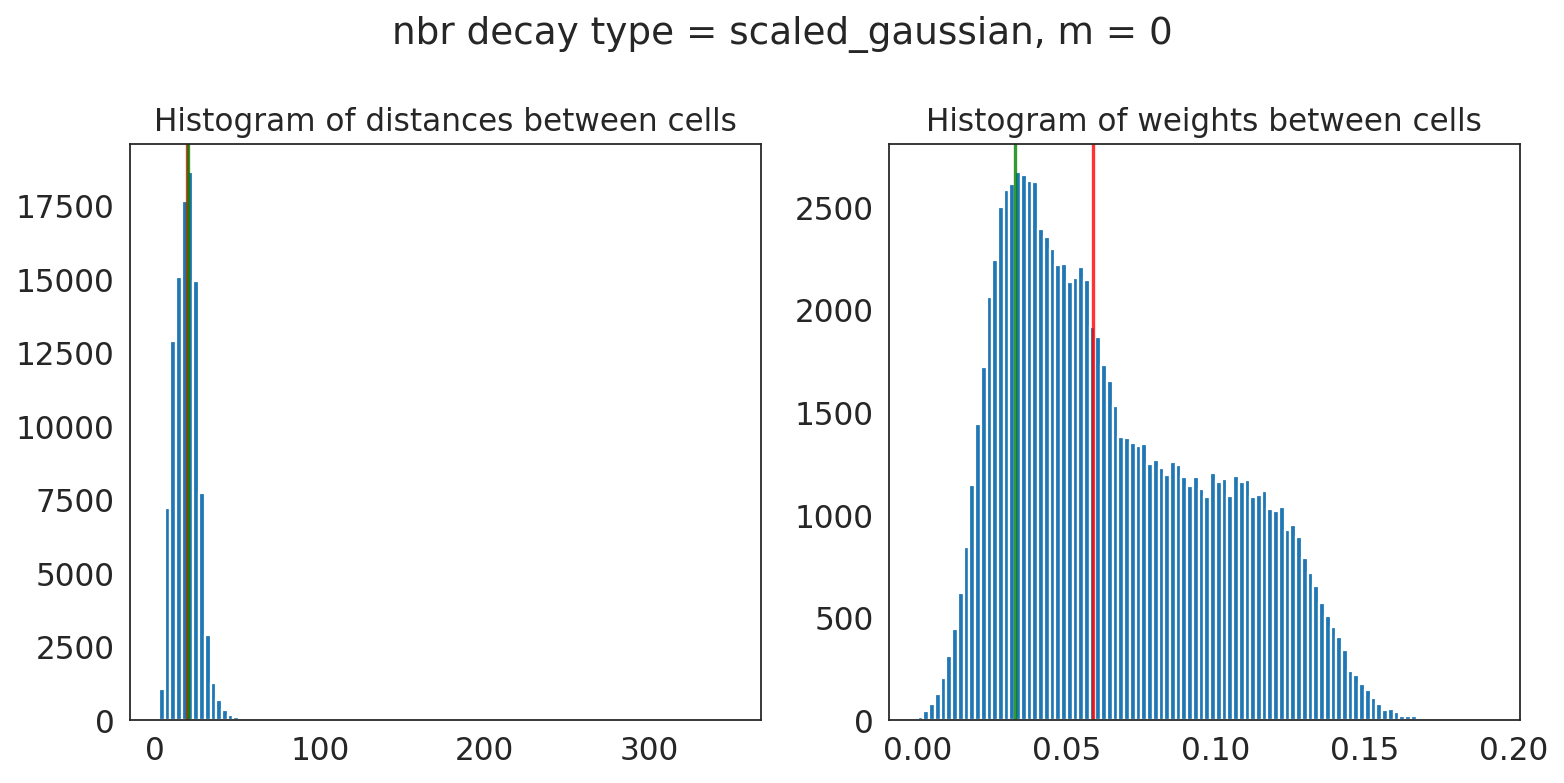

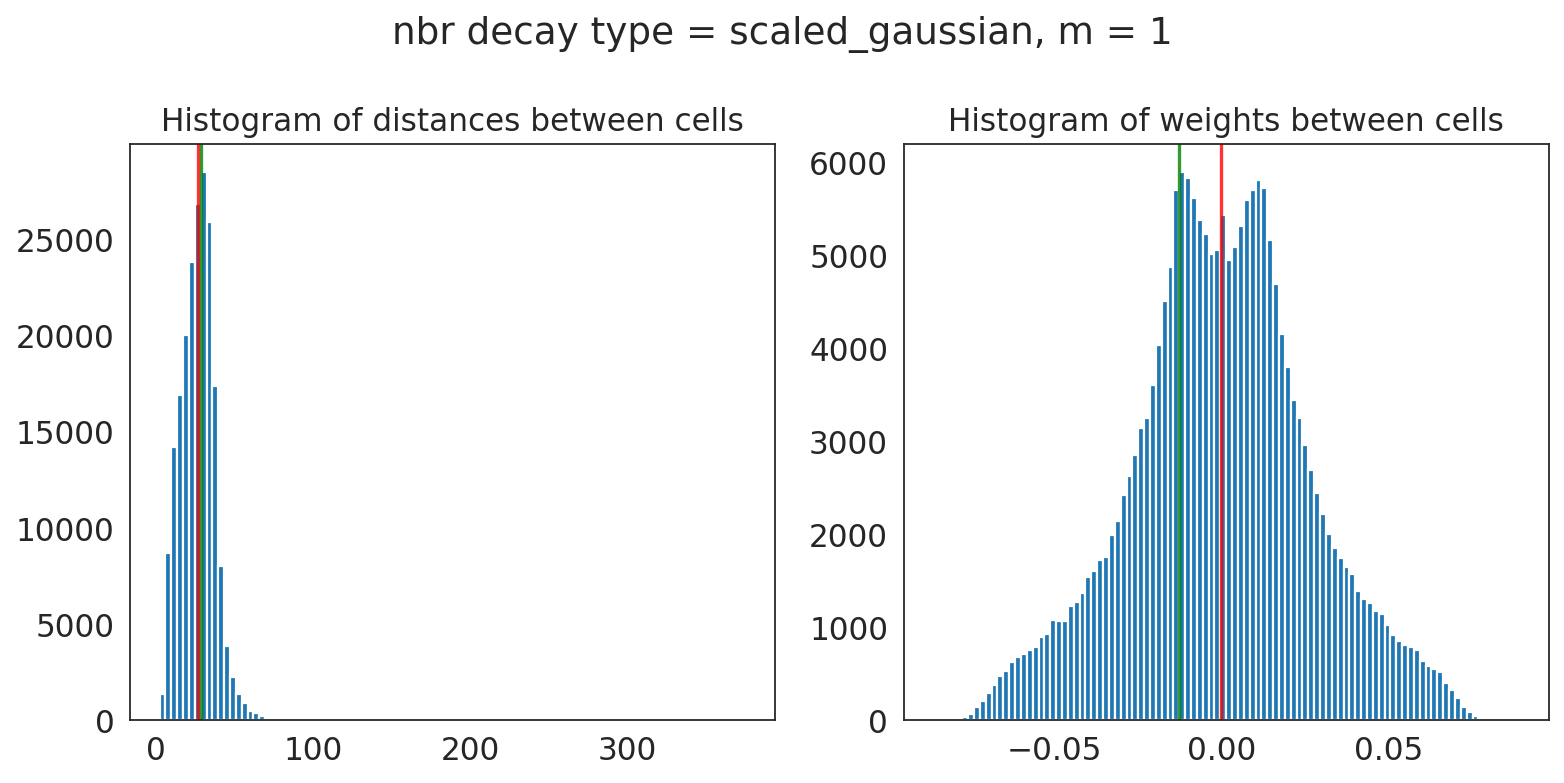

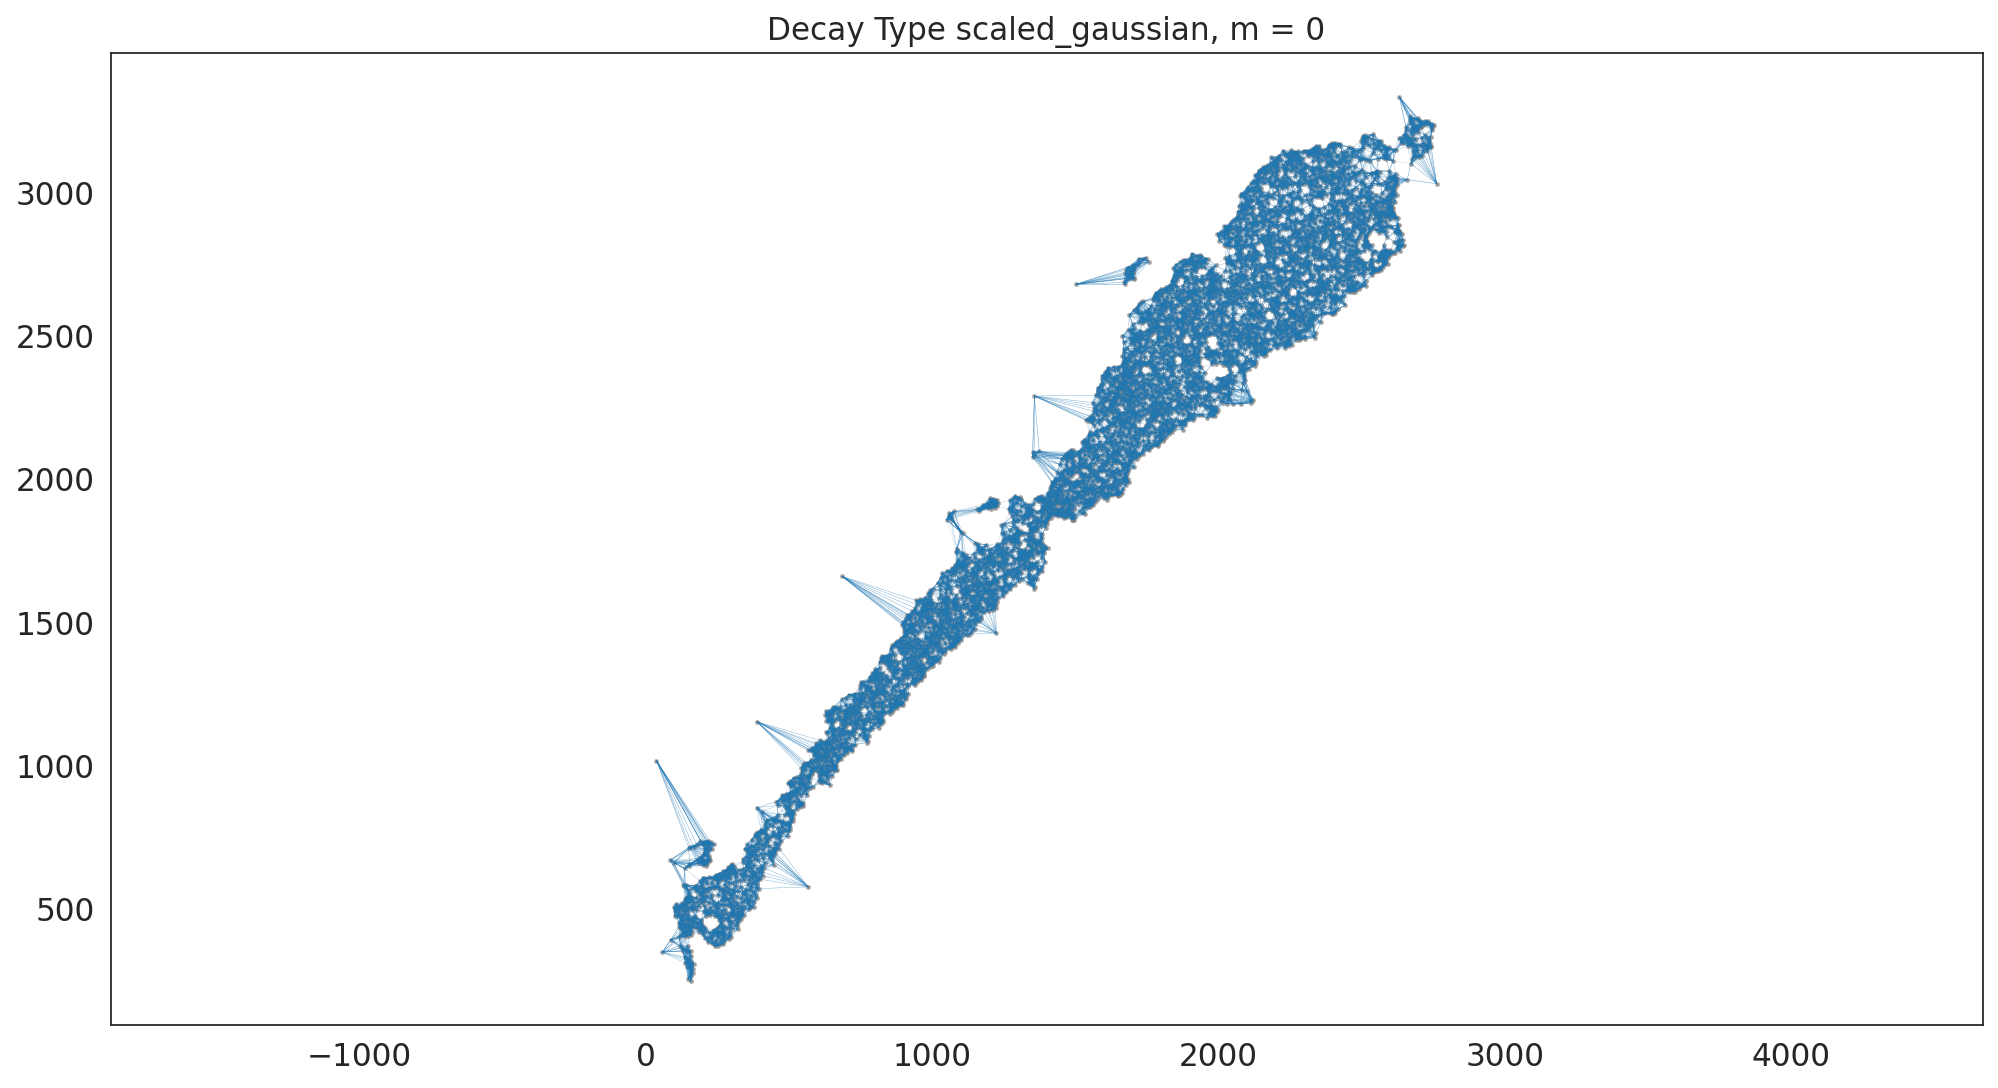

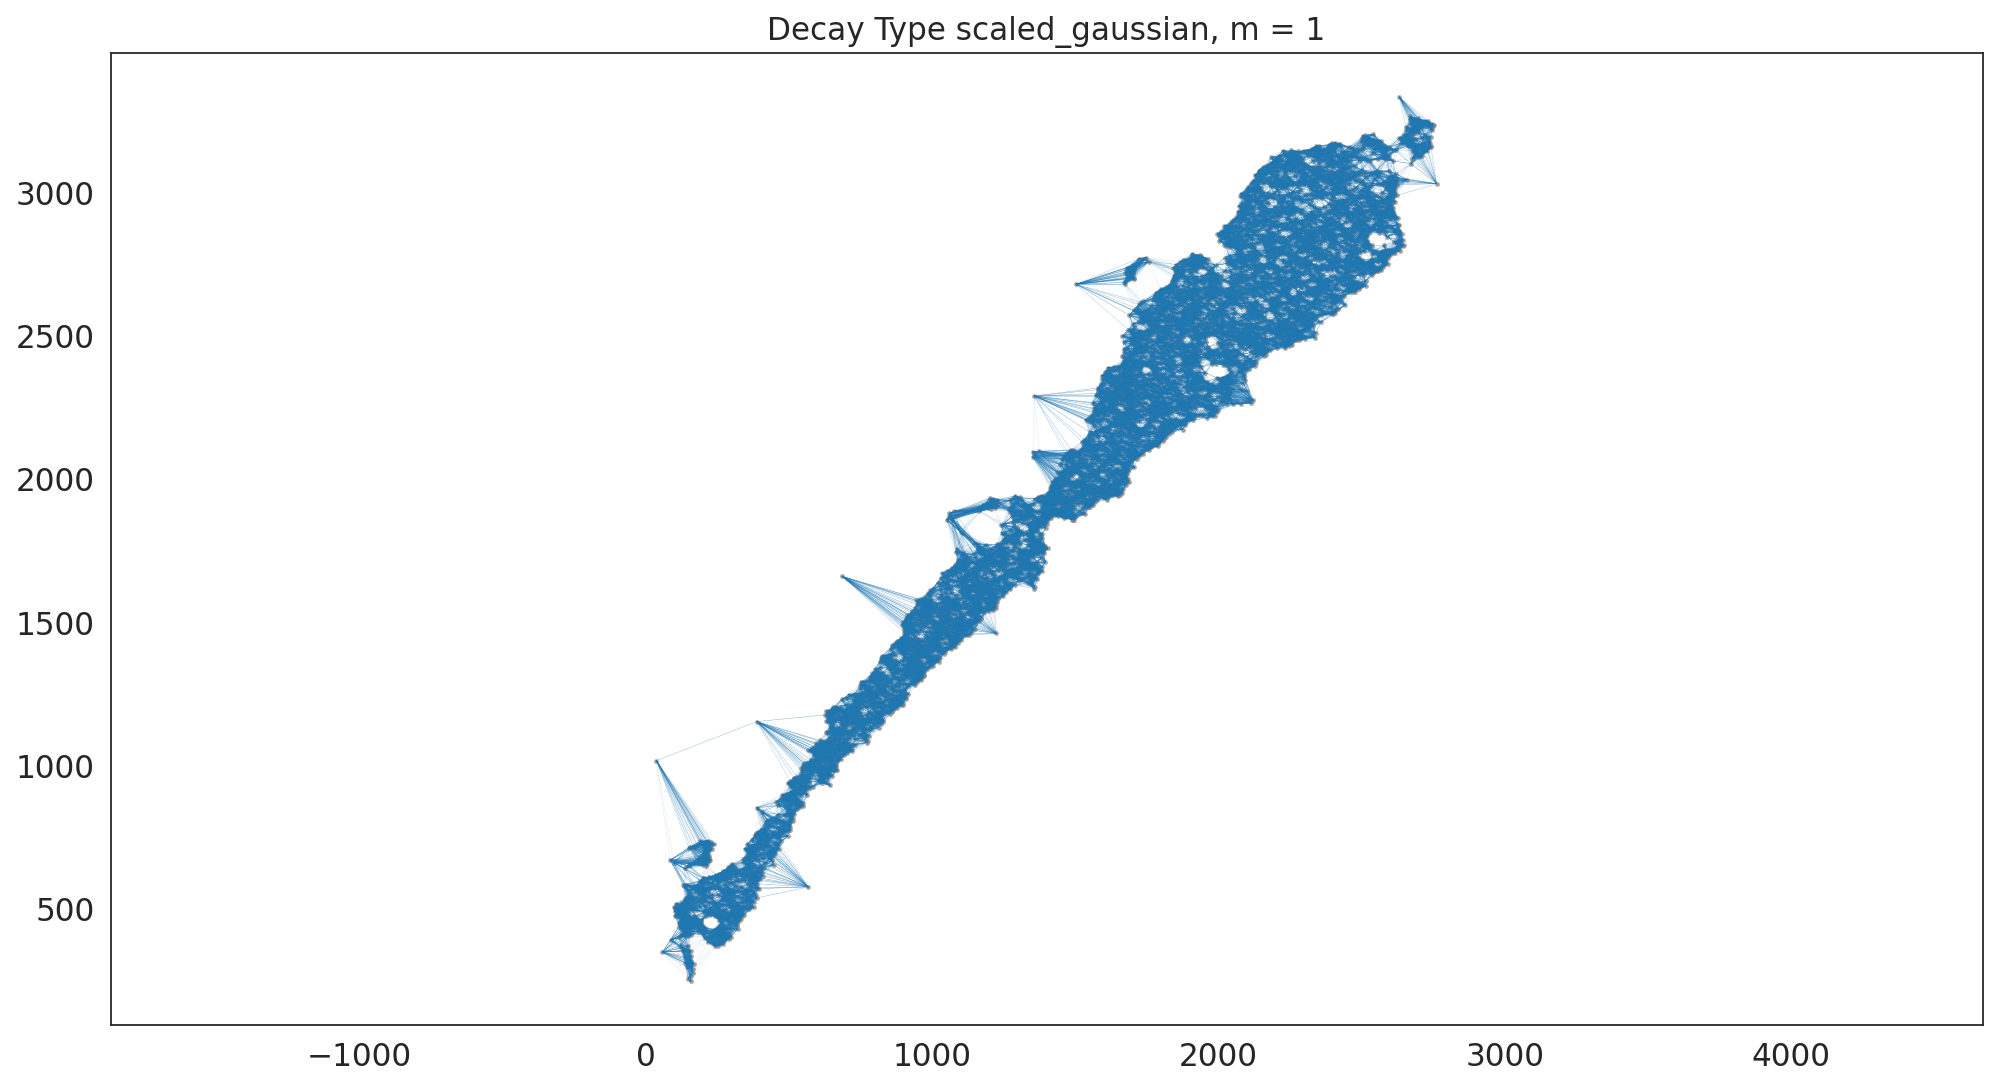

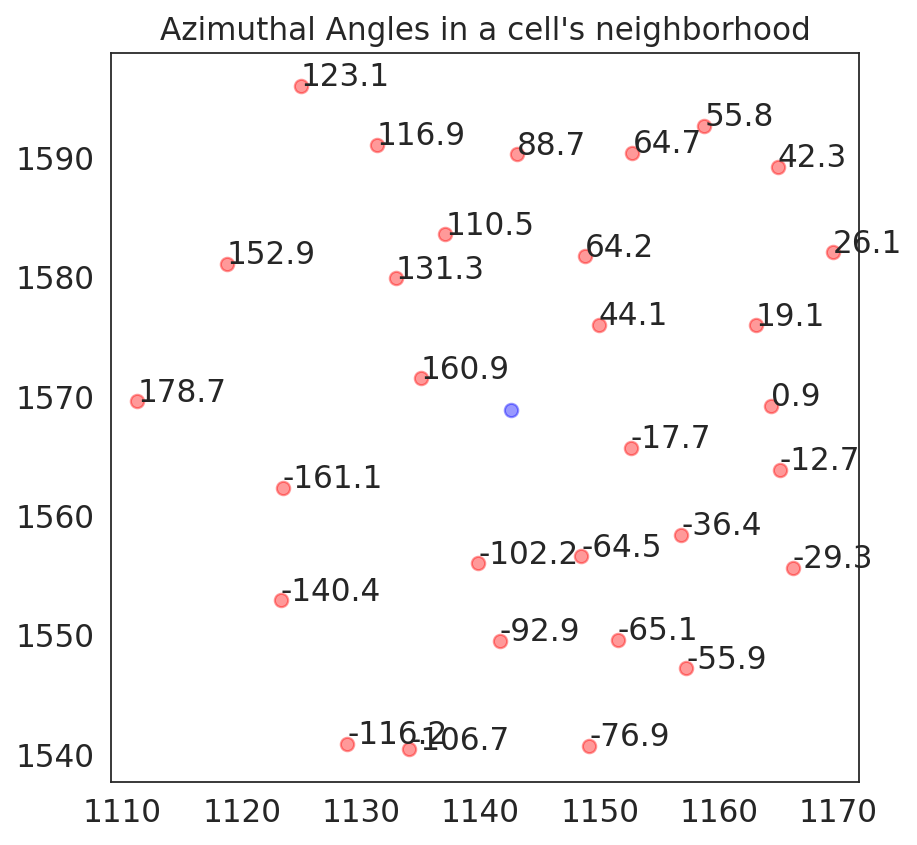

In [15]:
from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    coord_keys,
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=True,
    plt_nbr_weights=True,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=True,
)

## Generate BANKSY matrix

To generate the BANKSY matrix, we proceed with the following:

1. Matrix multiply sparse CSR weights matrix with cell-gene matrix to get **neighbour matrix** and the **AGF matrix** if `max_m` > 1
2. Z-score both matrices along **genes**
3. Multiply each matrix by a weighting factor $\lambda$ (We refer to this parameter as `lambda` in our manuscript and code)
4. Concatenate the matrices along the genes dimension in the form -> `horizontal_concat(cell_mat, nbr_mat, agf_mat)`

Here, we save all the results in the dictionary (`banksy_dict`), which contains the results from the subsequent operations for BANKSY. 

In [16]:
from banksy.embed_banksy import generate_banksy_matrix

# The following are the main hyperparameters for BANKSY
resolutions = [0.5] # clustering resolution for UMAP
pca_dims = [20] # Dimensionality in which PCA reduces to
lambda_list = [0.2, 0.5, 0.8] # list of lambda parameters

banksy_dict, banksy_matrix = generate_banksy_matrix(adata, banksy_dict, lambda_list, max_m)

Runtime May-26-2025-14-08

301 genes to be analysed:
Gene List:
Index(['ACER1', 'ACTA2', 'ADAM12', 'AHNAK2', 'AIF1', 'AKR1C1', 'ALOX5AP',
       'APCDD1', 'APOD', 'AQP1',
       ...
       'TYR', 'TYROBP', 'TYRP1', 'UBE2C', 'VCAM1', 'VEGFA', 'VIM', 'VWF',
       'WDFY4', 'ZNF667-AS1'],
      dtype='object', length=301)

Check if X contains only finite (non-NAN) values
Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <6760x6760 sparse matrix of type '<class 'numpy.float64'>'
	with 101400 stored elements in Compressed Sparse Row format>, 1: <6760x6760 sparse matrix of type '<class 'numpy.complex128'>'
	with 202800 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: 0.76 | Std: 1.91
Size of Nbr | Shape: (6760, 301)
Top 3 entries of Nbr Mat:

[[0.         0.76367654 0.77608946]
 [0.         1.00715772 0.16755168]
 [0.         1.23947521 0.19296271]]

AGF matrix | Mean: 0.22 | Std: 0.48
Size of AGF mat (m = 1) | Shape: (6760, 301)
Top entries of AGF:
[[0.      

### Append Non-spatial results to the `banksy_dict` for comparsion

In [17]:
from banksy.main import concatenate_all

banksy_dict["nonspatial"] = {
    # Here we simply append the nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

Scale factors squared: [1.]
Scale factors: [1.]
AnnData object with n_obs × n_vars = 6760 × 301
    obs: 'nucleus_area', 'nCount_Xenium', 'nFeature_Xenium', 'segmentation_method', 'nCount_BlankCodeword', 'nFeature_BlankCodeword', 'nCount_ControlCodeword', 'nFeature_ControlCodeword', 'nCount_ControlProbe', 'nFeature_ControlProbe', 'x', 'y', 'cell_area', 'nCount_SCT', 'nFeature_SCT'
    var: 'names', 'is_nbr', 'k'


## Reduce dimensions of each data matrix
We utilize two common methods for dimensionality reduction:

1. PCA (using `scikit-learn`), we reduce the size of the matrix from $3*N_{genes}$ to `pca_dims`. As a default settings, we reduce to 20 dimensions.
2. UMAP (`UMAP` package), which we use to visualize expressions of clusters in the umap space (2-D space).

In [18]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         )

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.2)

Setting the total number of PC = 20
Original shape of matrix: (6760, 903)
Reduced shape of matrix: (6760, 20)
------------------------------------------------------------
min_value = -21.091334583123583, mean = -4.86868927816684e-16, max = 28.731656734745506

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_20_umap"]
UMAP embedding
------------------------------------------------------------
shape: (6760, 2)


AxisArrays with keys: reduced_pc_20, reduced_pc_20_umap

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.5)

Setting the total number of PC = 20
Original shape of matrix: (6760, 903)
Reduced shape of matrix: (6760, 20)
------------------------------------------------------------
min_value = -10.222057459278295, mean = -1.8919776987694976e-16, max = 18.856585798730503

Conducting UMAP and adding embeddings to adata.obsm["reduc

### Cluster cells using a partition algorithm

For the purpose of this dataset, we cluster cells using the `leiden` algorithm (use `!pip install leidenalg` if package missing) partition methods. Other clustering algorithms include `louvain` (another resolution based clustering algorithm), or `mclust` (a clustering based on gaussian mixture model). 

Note that by default, we recommend resolution-based clustering (i.e., `leiden` or `louvain`) if no prior information on the number of clusters known. However, if the number of clusters is known *a priori*, the user can use `mclust` (gaussian-mixture model) by specifying the number of clusters beforehand.

In [21]:
#from banksy.cluster_methods import run_Leiden_partition
from banksy.cluster_methods import run_Leiden_partition_parallel

# results_df, max_num_labels = run_Leiden_partition(
#     banksy_dict,
#     resolutions,
#     num_nn = 50,
#     num_iterations = -1,
#     partition_seed = seed,
#     match_labels = True,
# )

# Parallelisation test
results_df, max_num_labels = run_Leiden_partition_parallel(
    banksy_dict,
    resolutions,
    num_nn=50,
    max_workers=8
)

''' Looking at the CPU in HTOP, they all went up to 100% when I ran this so I think it works!
Just need to compare the time taken to complete clustering with this function (20.9s) to the original function 
'''


reduced_pc_20 

reduced_pc_20_umap 

reduced_pc_20 

reduced_pc_20_umap 

reduced_pc_20 

reduced_pc_20_umap 

reduced_pc_20 

reduced_pc_20_umap 


Nearest-neighbour weighted graph (dtype: float64, shape: (6760, 6760)) has 338000 nonzero entries.
---- Ran find_nn in 1.99 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (6760, 6760)) has 338000 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 4417328 to 337643.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (6760, 6760)) has 327432 nonzero entries.
Nearest-neighbour weighted graph (dtype: float64, shape: (6760, 6760)) has 338000 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (6760, 6760)) has 327432 nonzero entries.
---- Ran find_nn in 2.27 s ----



sNN graph data:
[24 22 20 ... 21 13  9]

---- Ran shared_nn in 0.52 s ----


-- Multiplying sNN connectivity by 

param_str  \
nonspatial_pc20_nc0.00_r0.50            nonspatial_pc20_nc0.00_r0.50   
scaled_gaussian_pc20_nc0.20_r0.50  scaled_gaussian_pc20_nc0.20_r0.50   
scaled_gaussian_pc20_nc0.50_r0.50  scaled_gaussian_pc20_nc0.50_r0.50   
scaled_gaussian_pc20_nc0.80_r0.50  scaled_gaussian_pc20_nc0.80_r0.50   

                                             decay  lambda_param  num_pcs  \
nonspatial_pc20_nc0.00_r0.50            nonspatial           0.0       20   
scaled_gaussian_pc20_nc0.20_r0.50  scaled_gaussian           0.2       20   
scaled_gaussian_pc20_nc0.50_r0.50  scaled_gaussian           0.5       20   
scaled_gaussian_pc20_nc0.80_r0.50  scaled_gaussian           0.8       20   

                                   resolution  num_labels  \
nonspatial_pc20_nc0.00_r0.50              0.5           7   
scaled_gaussian_pc20_nc0.20_r0.50         0.5           8   
scaled_gaussian_pc20_nc0.50_r0.50         0.5           7   
scaled_gaussian_pc20_nc0.80_r0.50         0.5           8   

                                                                              labels  \
nonspatial_pc20_nc0.00_r0.50       Label object:\nNumber of labels: 7, number of ...   
scaled_gaussian_pc20_nc0.20_r0.50  Label object:\nNumber of labels: 8, number of ...   
scaled_gaussian_pc20_nc0.50_r0.50  Label object:\nNumber of labels: 7, number of ...   
scaled_gaussian_pc20_nc0.80_r0.50  Label object:\nNumber of labels: 8, number of ...   

                                                                               adata  \
nonspatial_pc20_nc0.00_r0.50       [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.20_r0.50  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.50_r0.50  [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.80_r0.50  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
nonspatial_pc20_nc0.00_r0.50       Label object:\nNumber of labels: 7, number of ...  
scaled_gaussian_pc20_nc0.20_r0.50  Label object:\nNumber of labels: 8, number of ...  
scaled_gaussian_pc20_nc0.50_r0.50  Label object:\nNumber of labels: 7, number of ...  
scaled_gaussian_pc20_nc0.80_r0.50  Label object:\nNumber of labels: 8, number of ...

' Looking at the CPU in HTOP, they all went up to 100% when I ran this so I think it works!\nJust need to compare the time taken to complete clustering with this function (20.9s) to the original function \n'

## Plot results

### Visualize the clustering results from BANKSY, including the clusters from the Umap embbedings

Saving figure at data/xenium/processed/tmp_png/ck_skin_res_nonspatial_pc20_nc0.00_r0.50_spatialmap.png
number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 7
---- Ran plot_2d_embeddings in 0.00 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((7, 6760) x (6760, 6760) x (6760, 7))

Saving figure at data/xenium/processed/tmp_png/ck_skin_res_scaled_gaussian_pc20_nc0.20_r0.50_spatialmap.png
number of labels: 8
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 8
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 8
---- Ran plot_2d_embeddings in 0.00 s ----

---- Ran row_normalize in 0.00 s ----


matrix multiplying labels x weights x labels-transpose ((8, 6760) x (6760, 6760) x (6760, 8))

Saving figure at data/xenium/processed/tmp_png/ck_skin_res_scaled_gaussian_pc20_nc0.50_r0.50_spatialmap.png
number of labels: 7
---- Ra

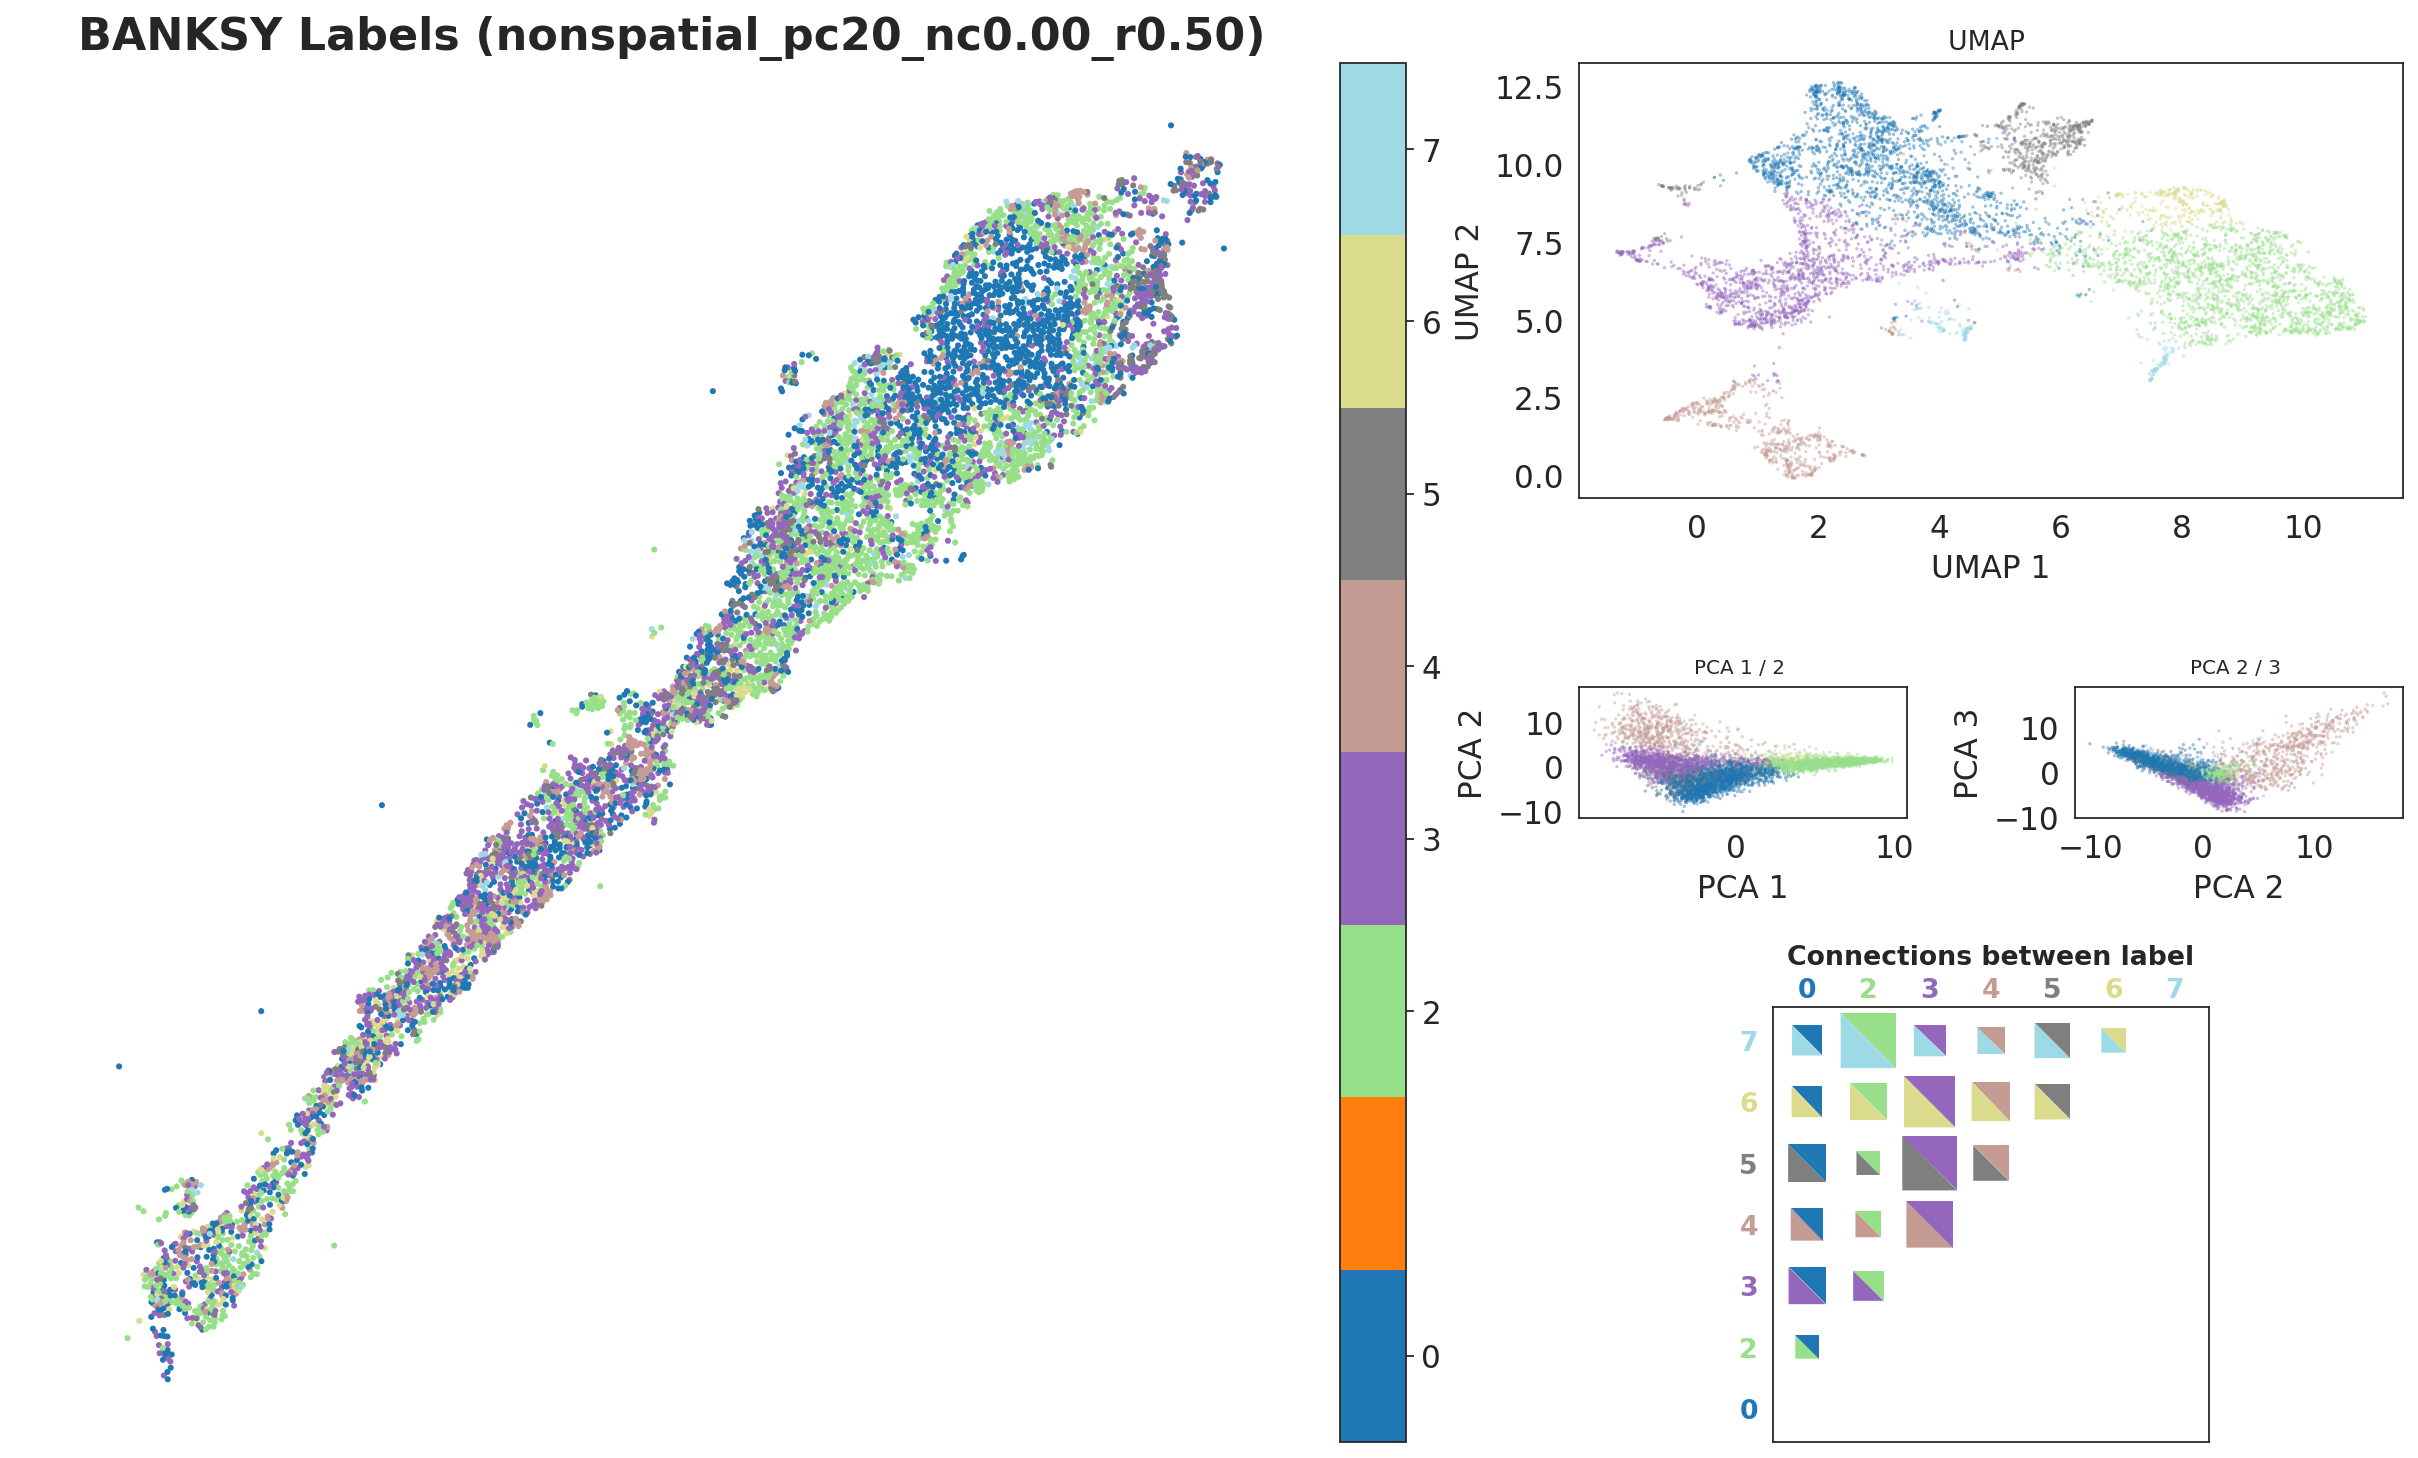

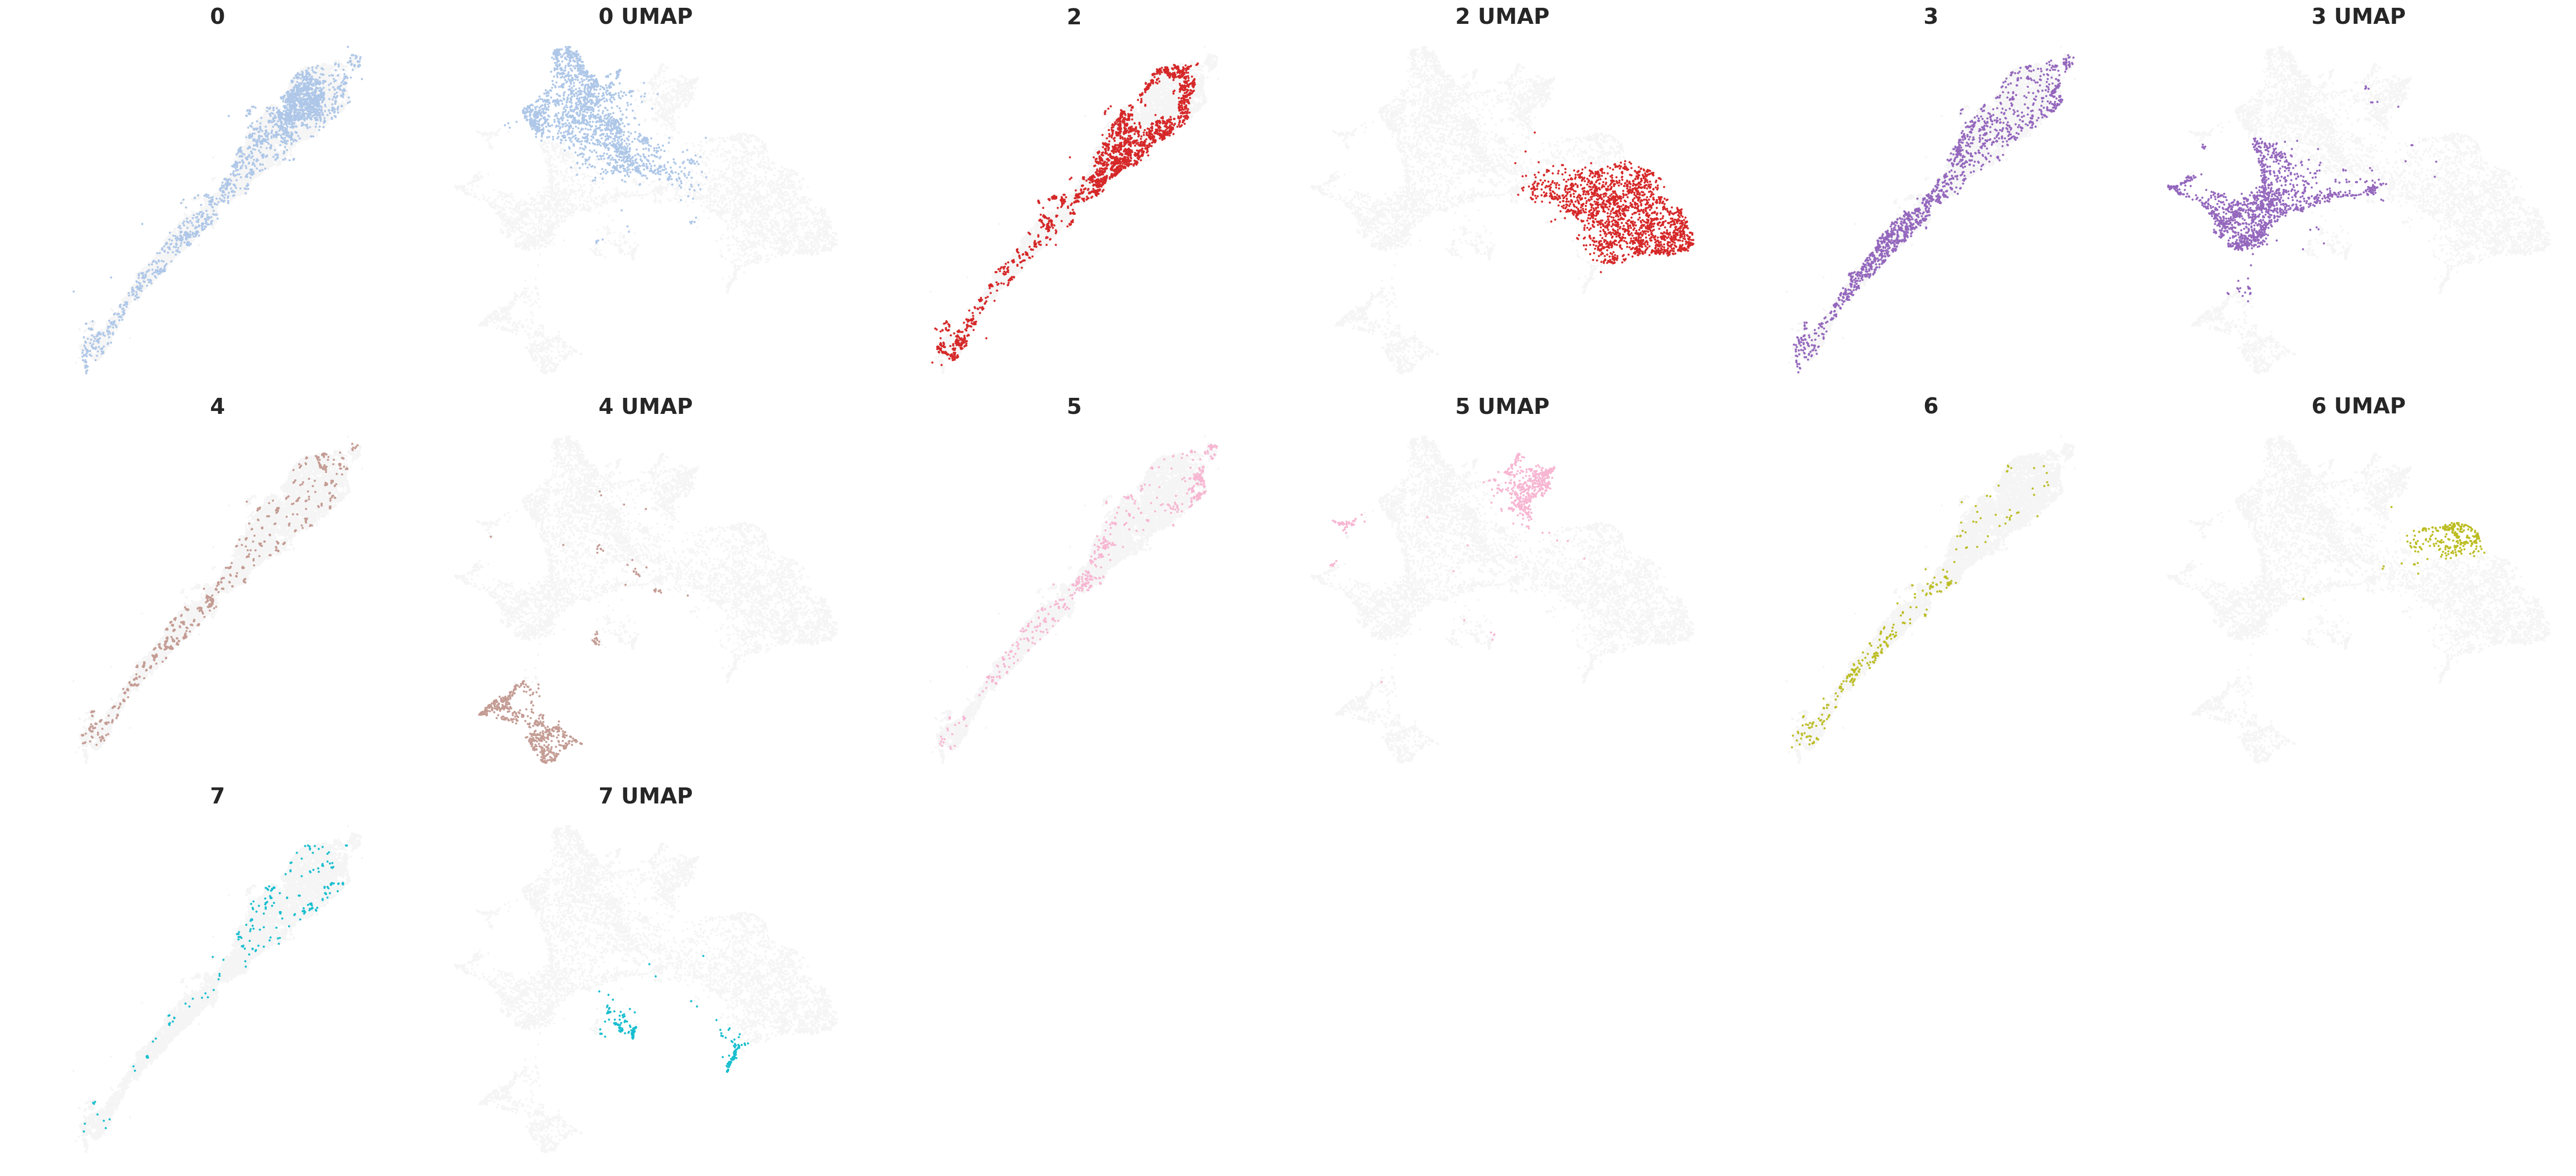

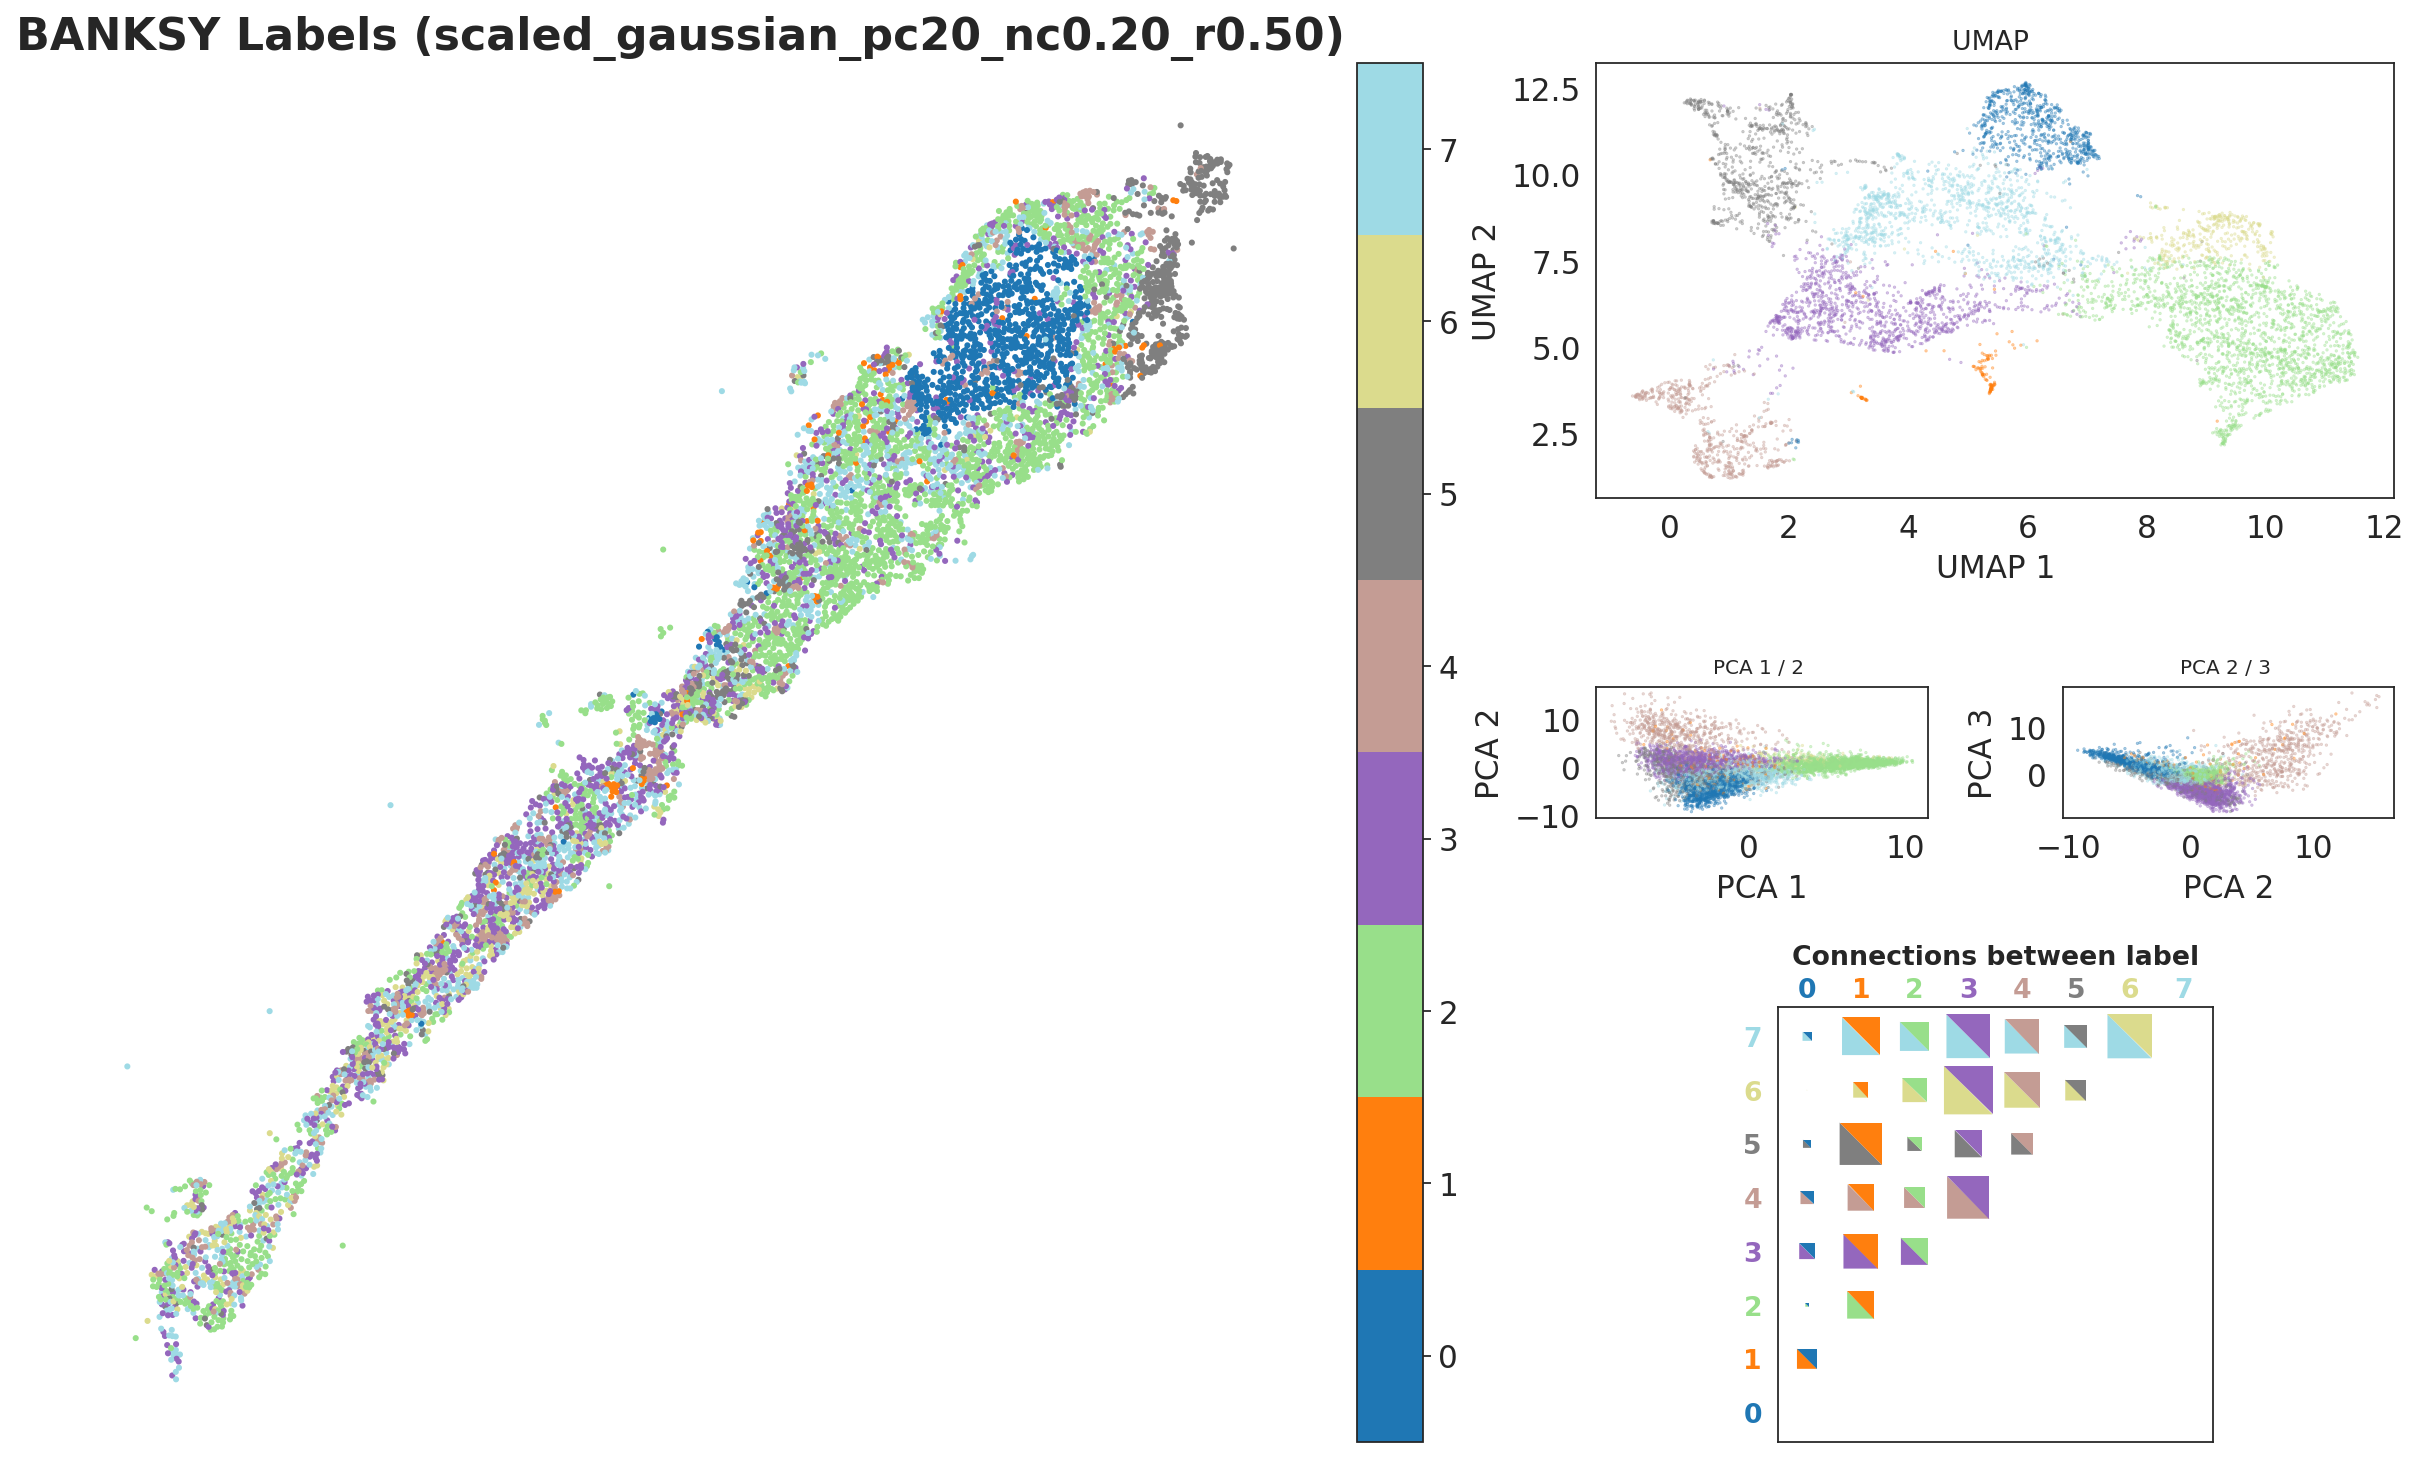

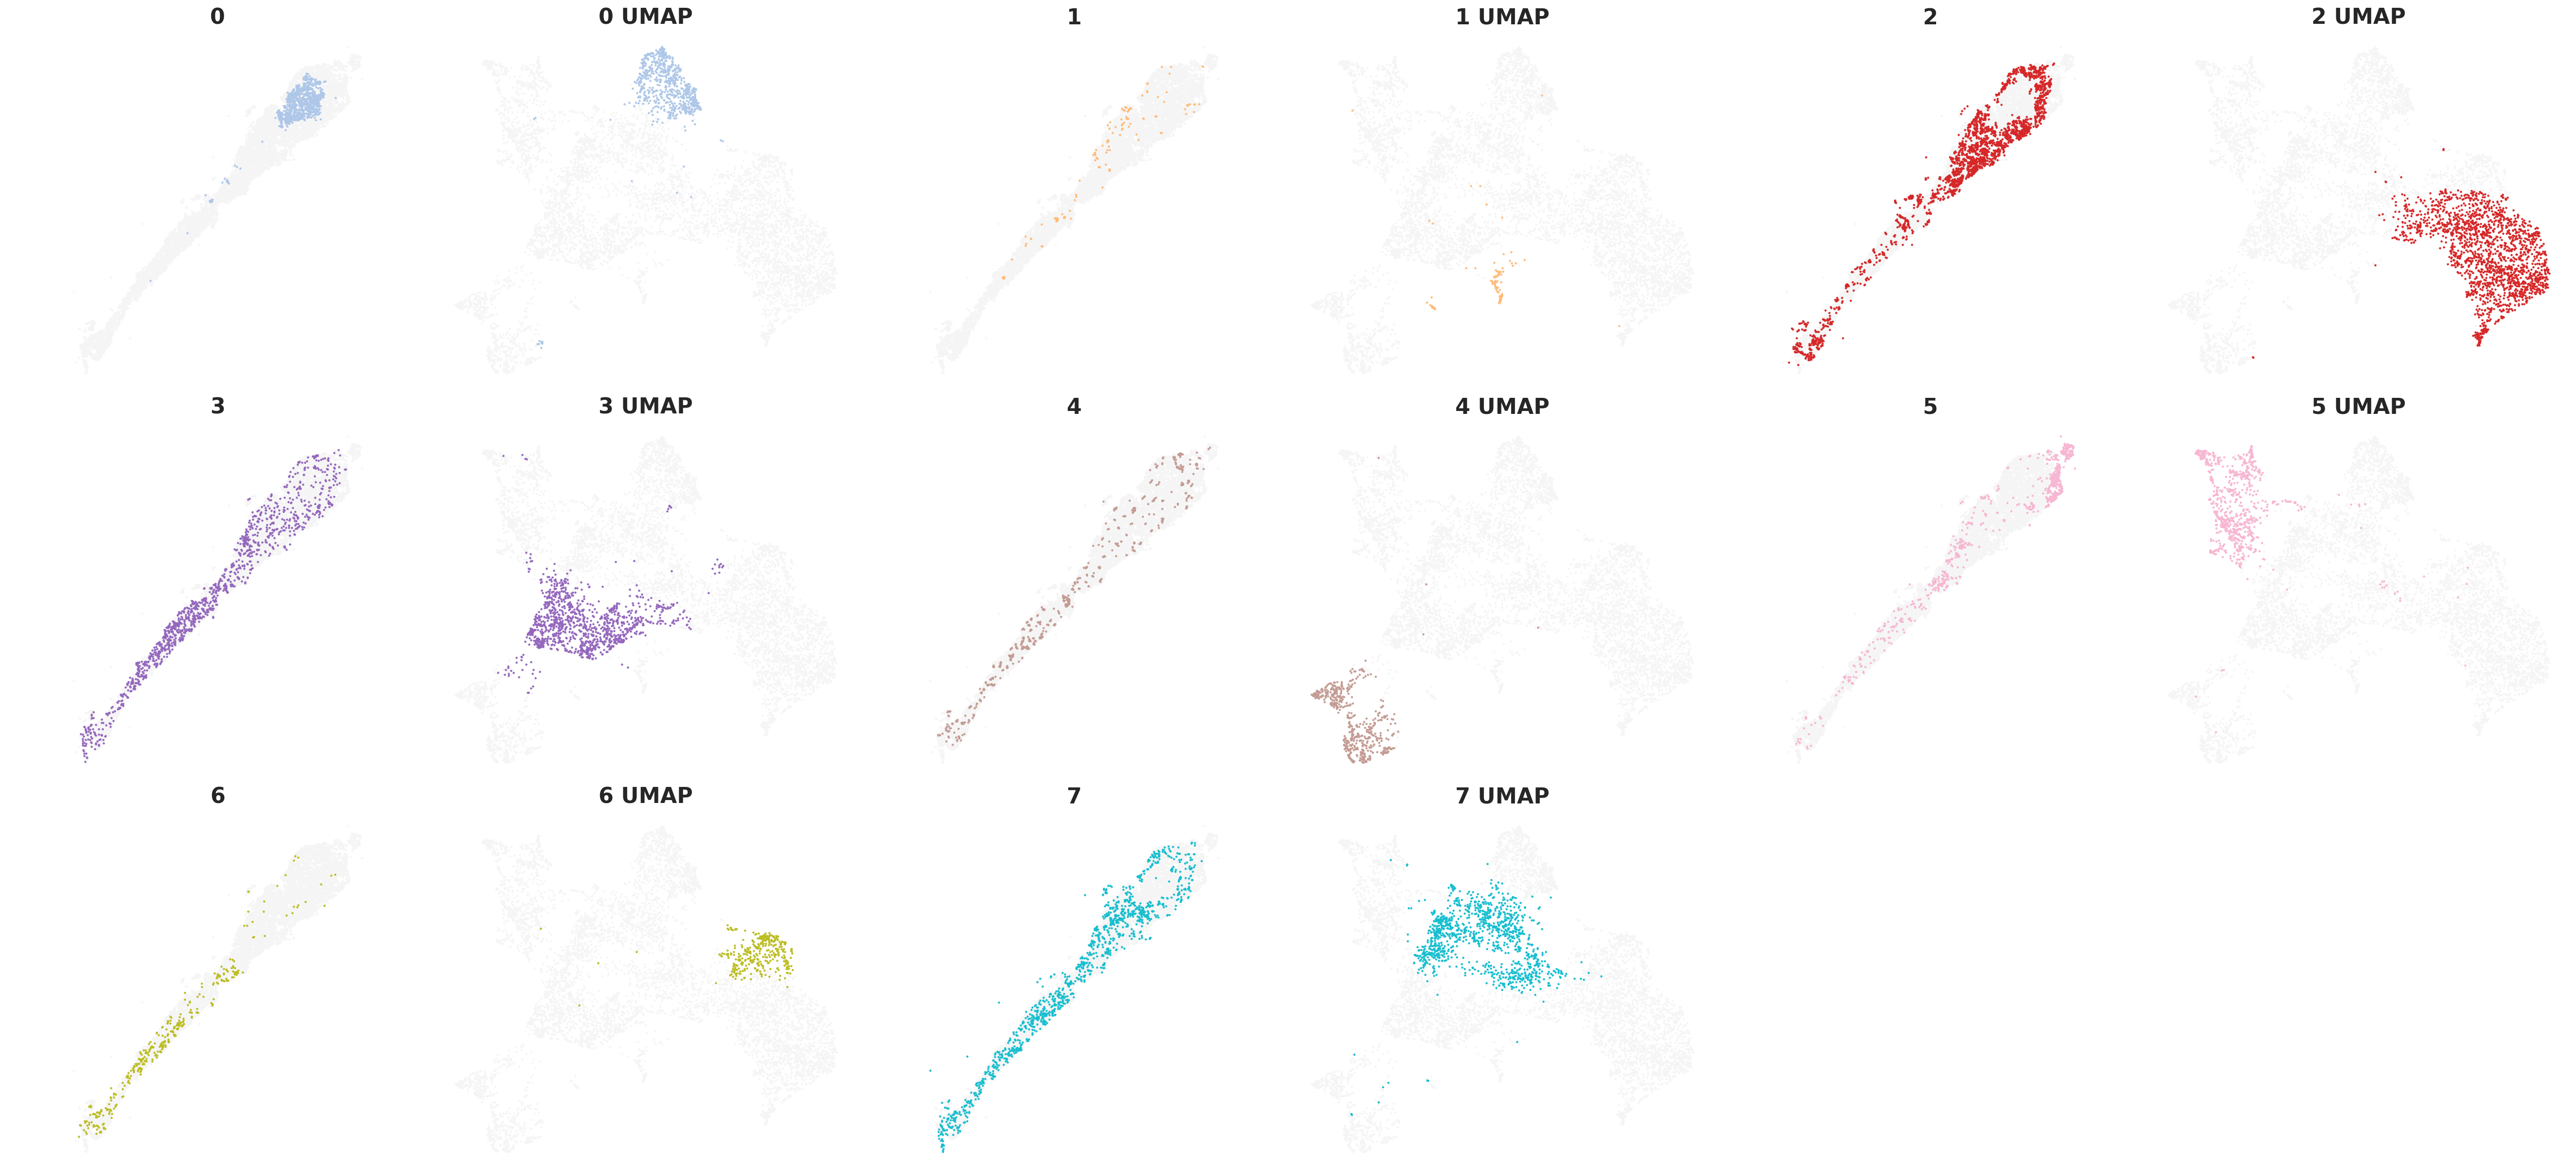

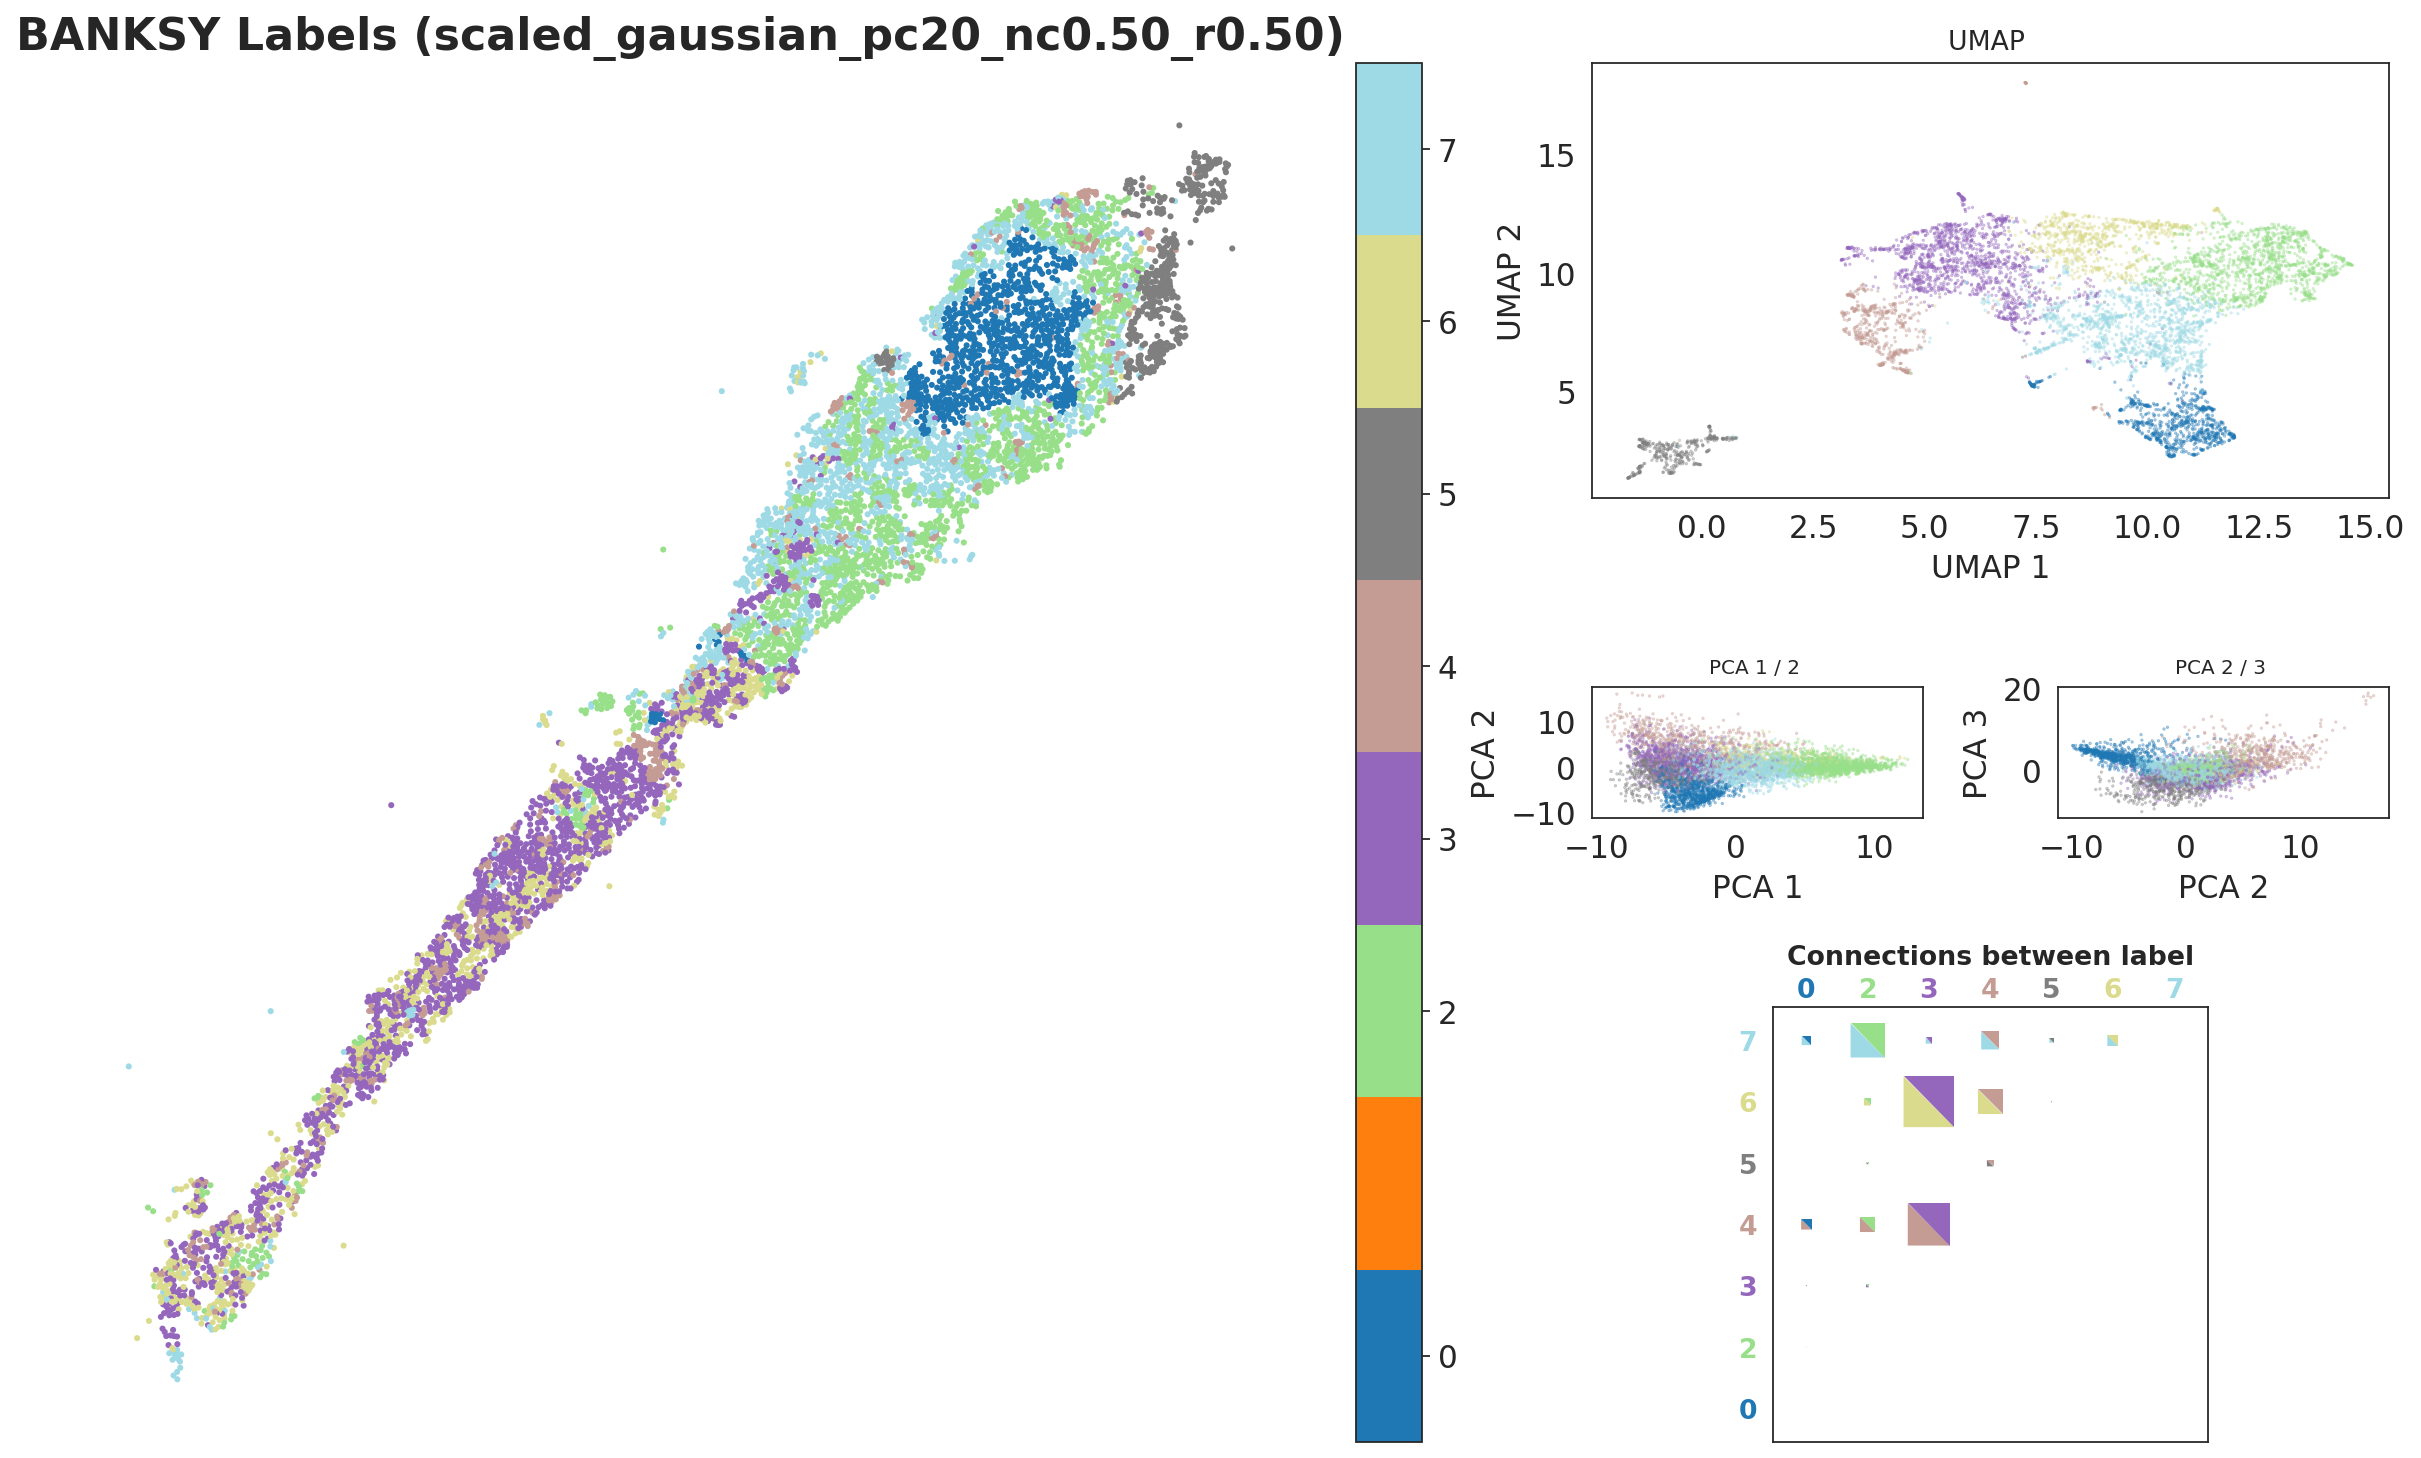

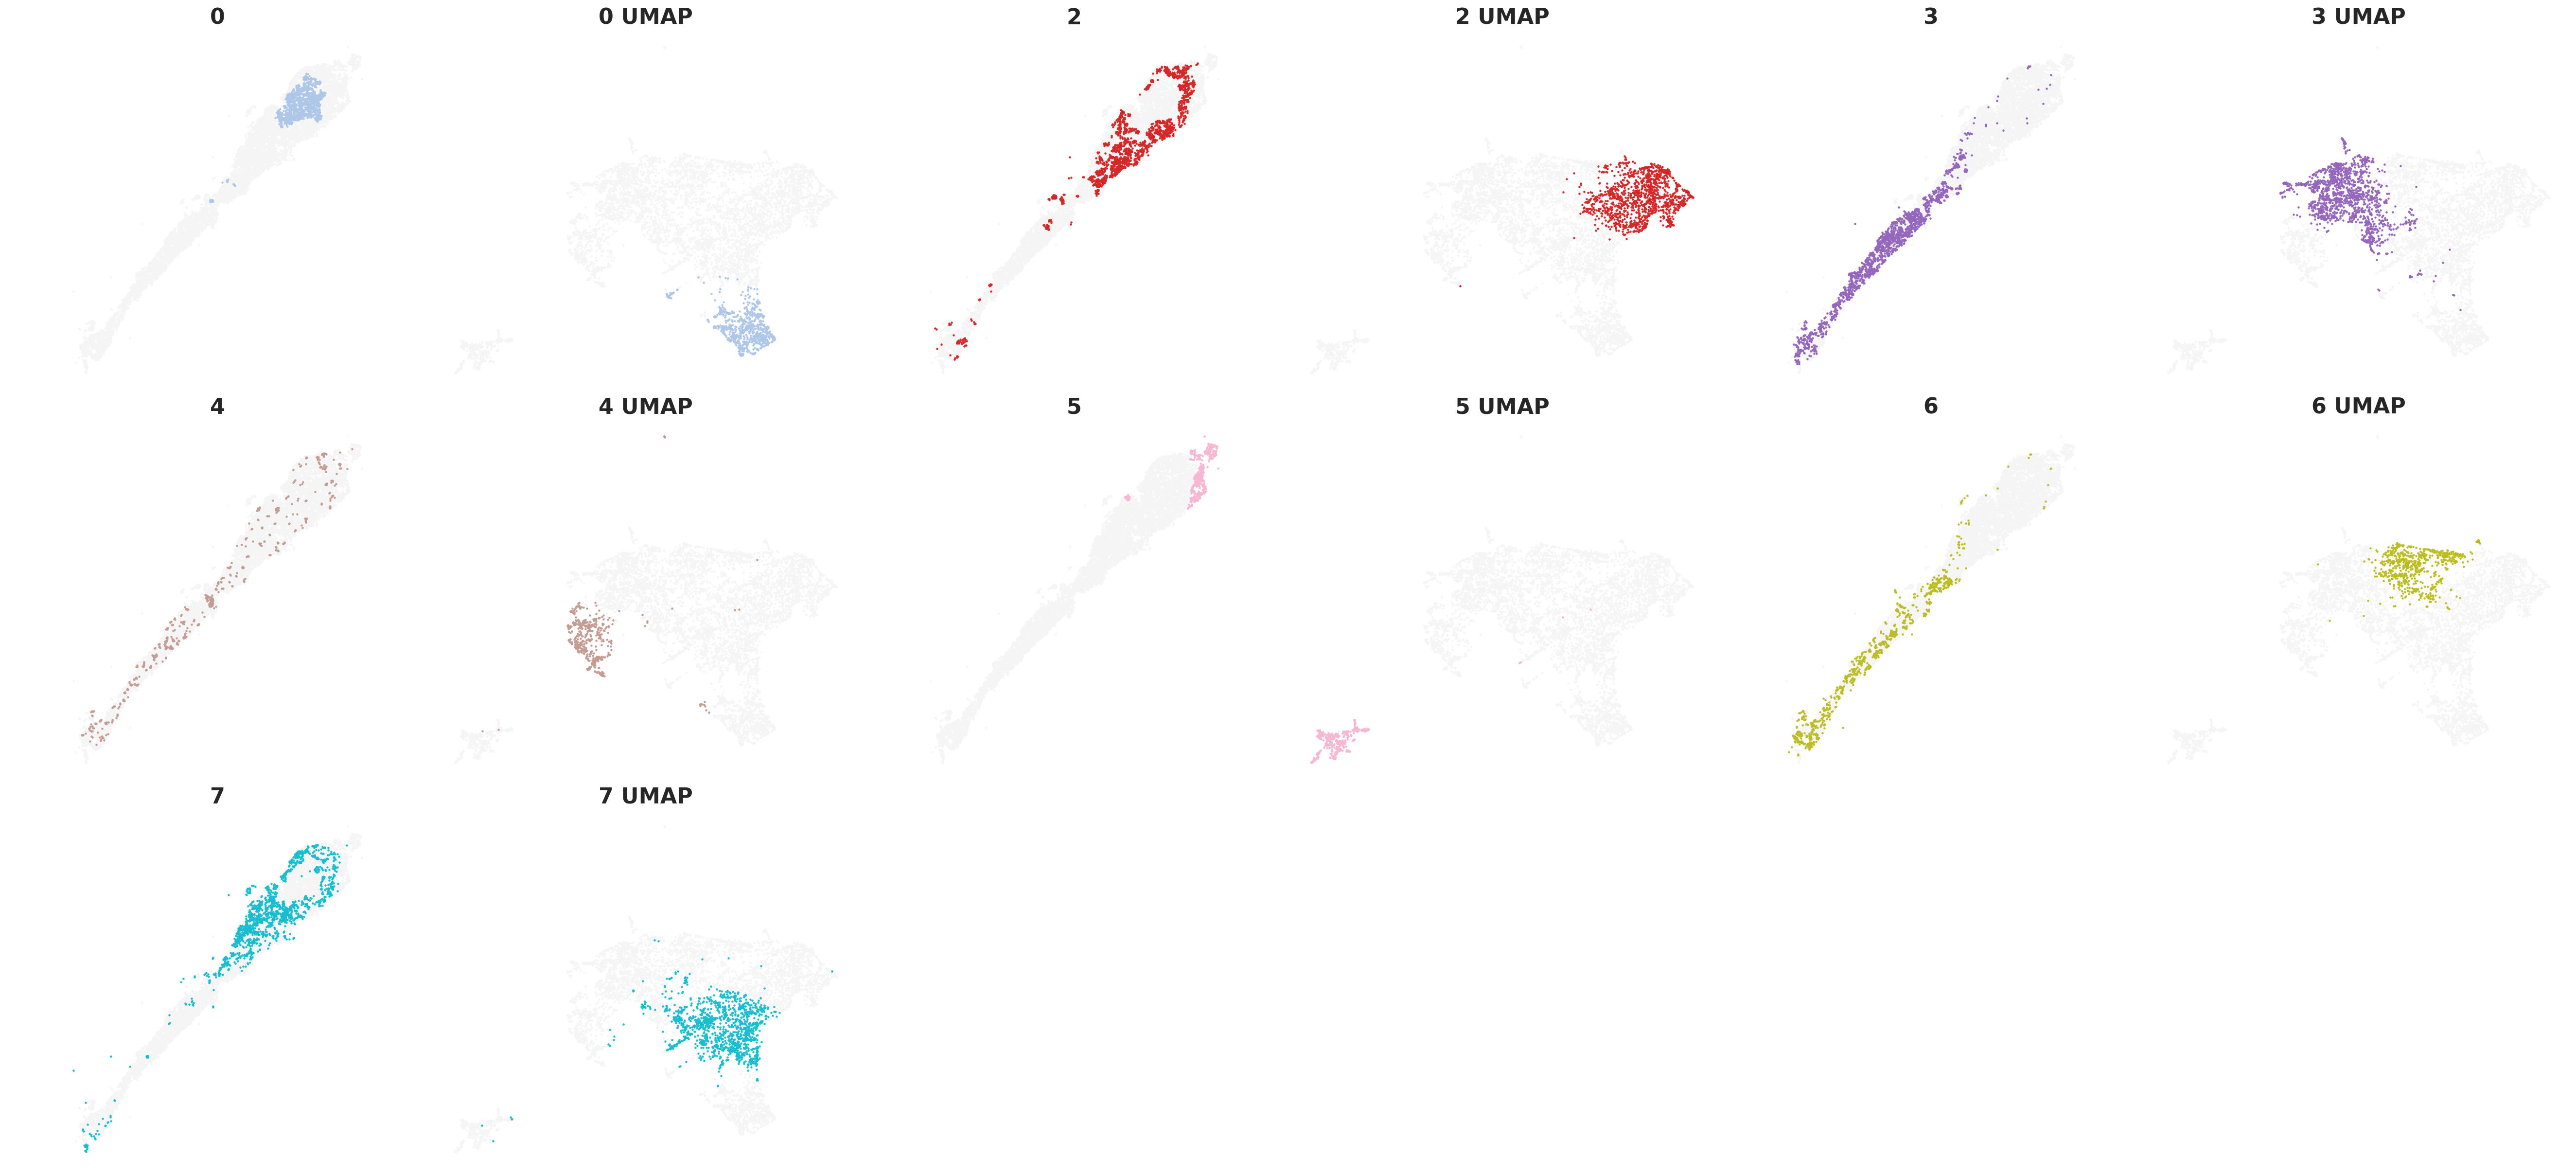

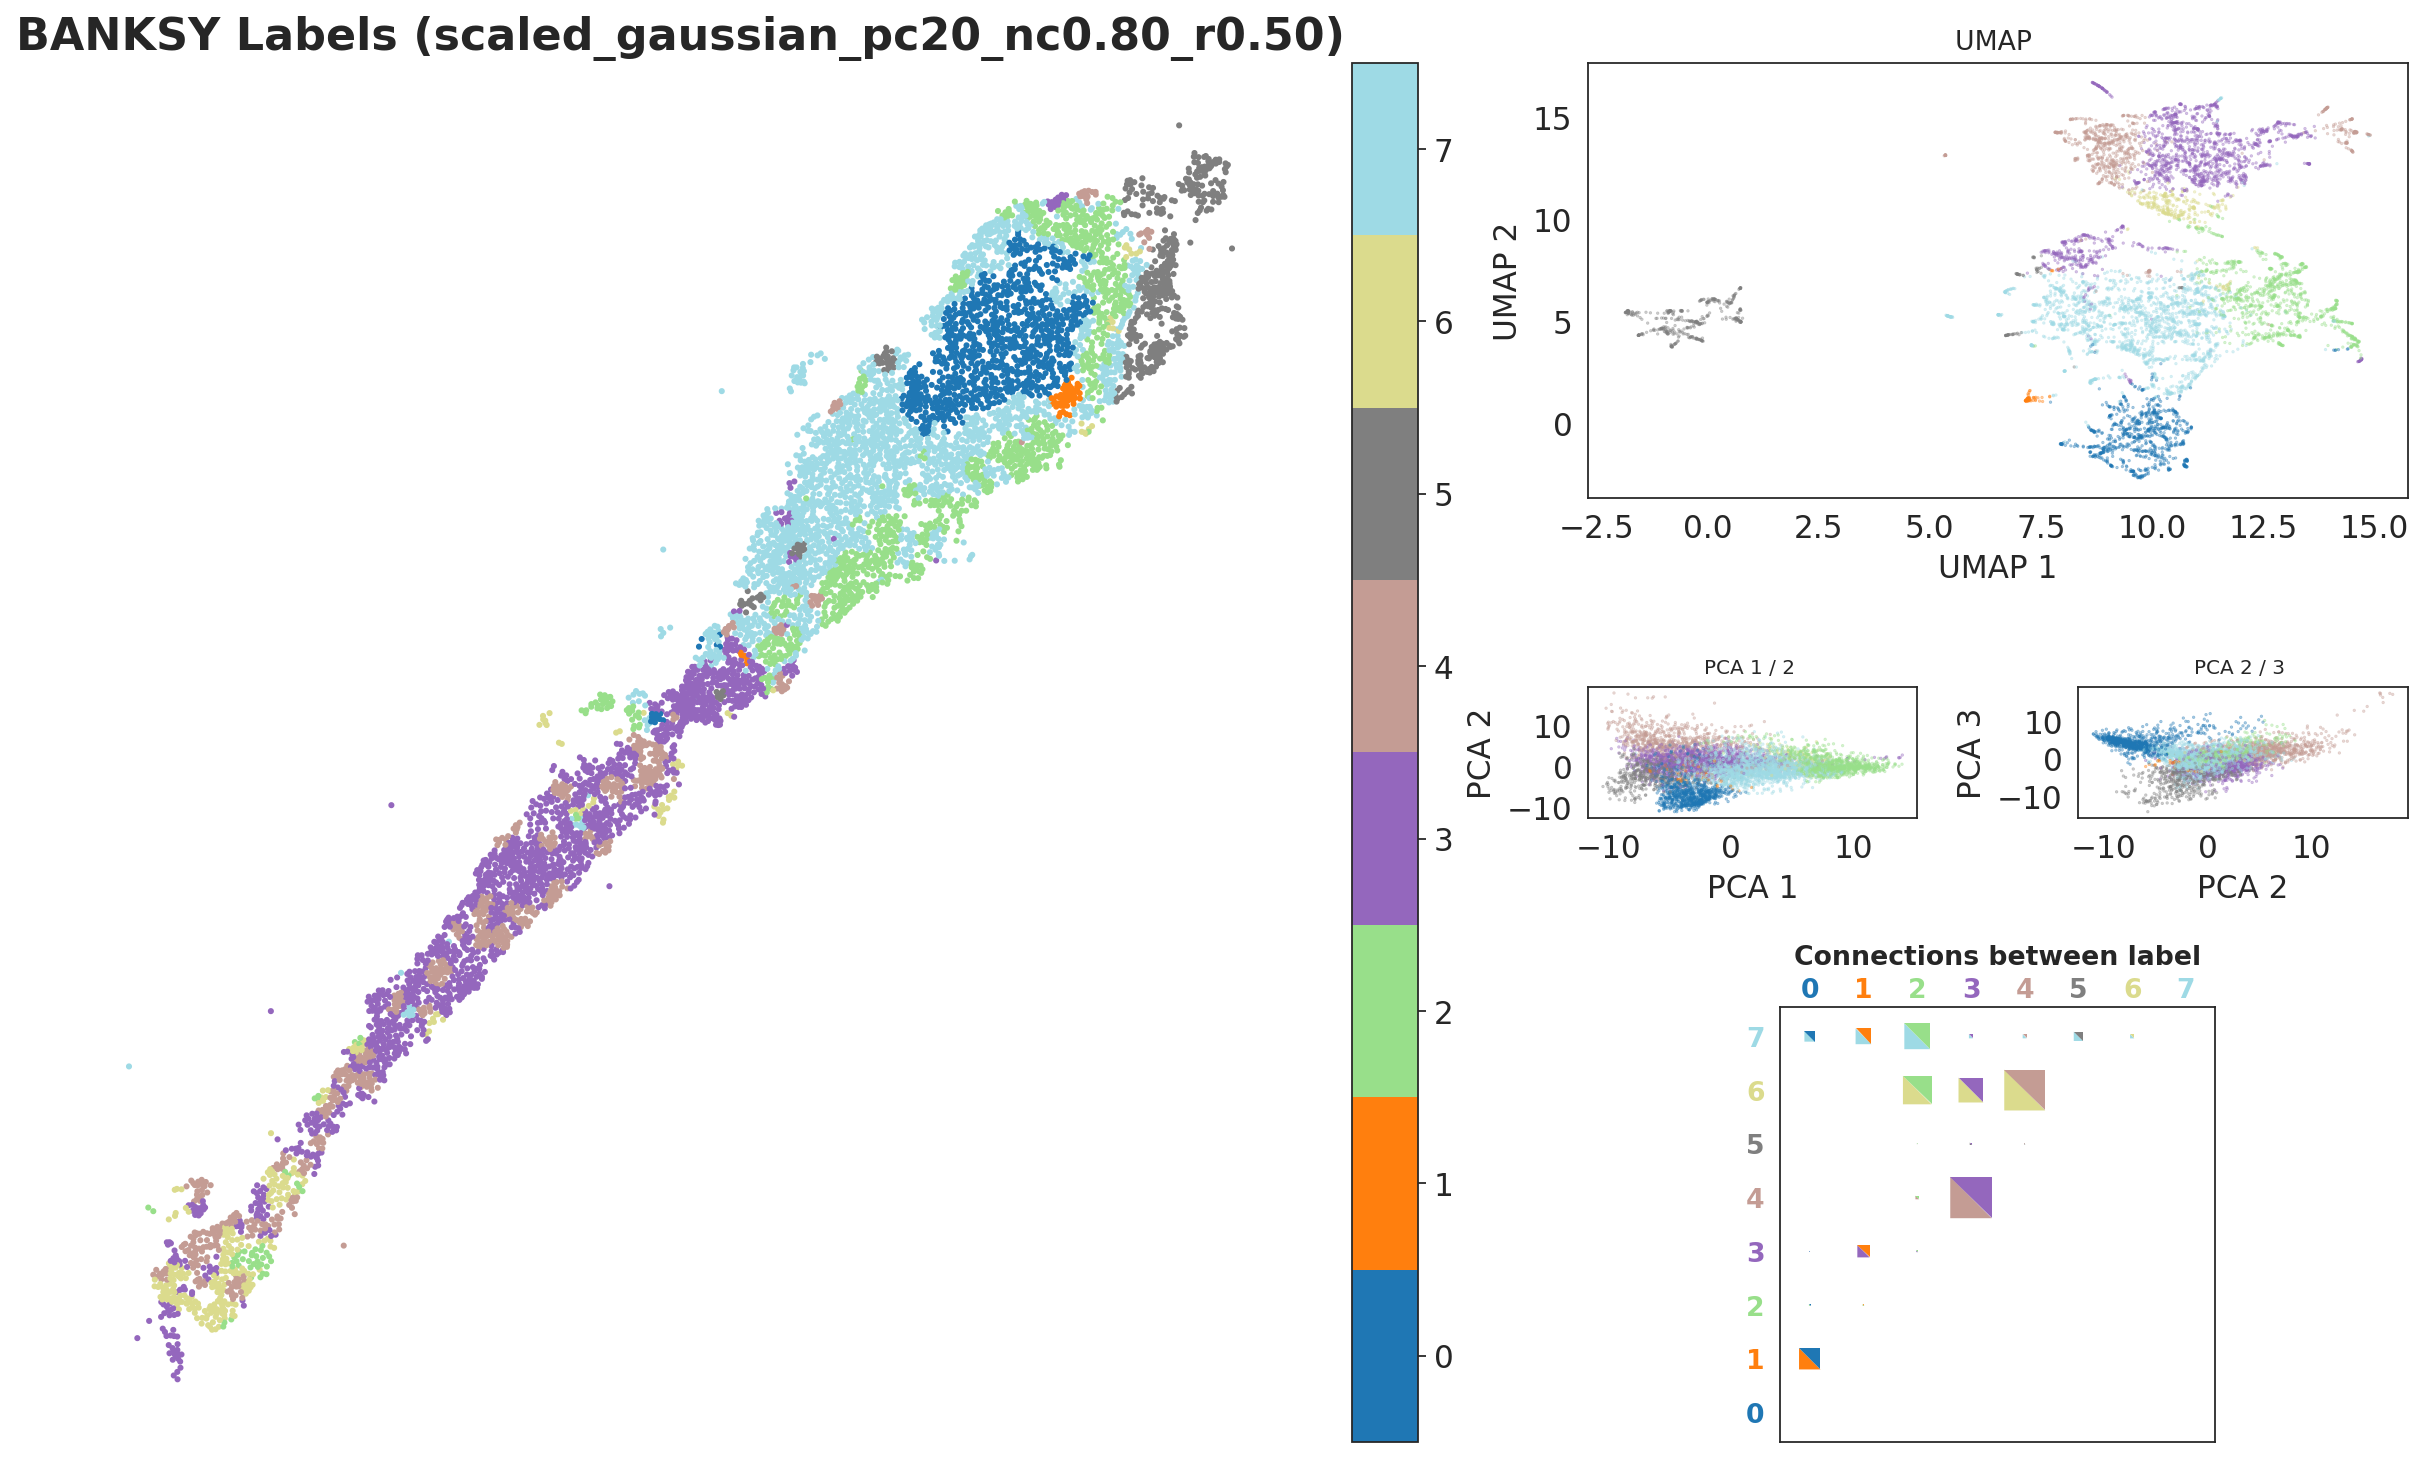

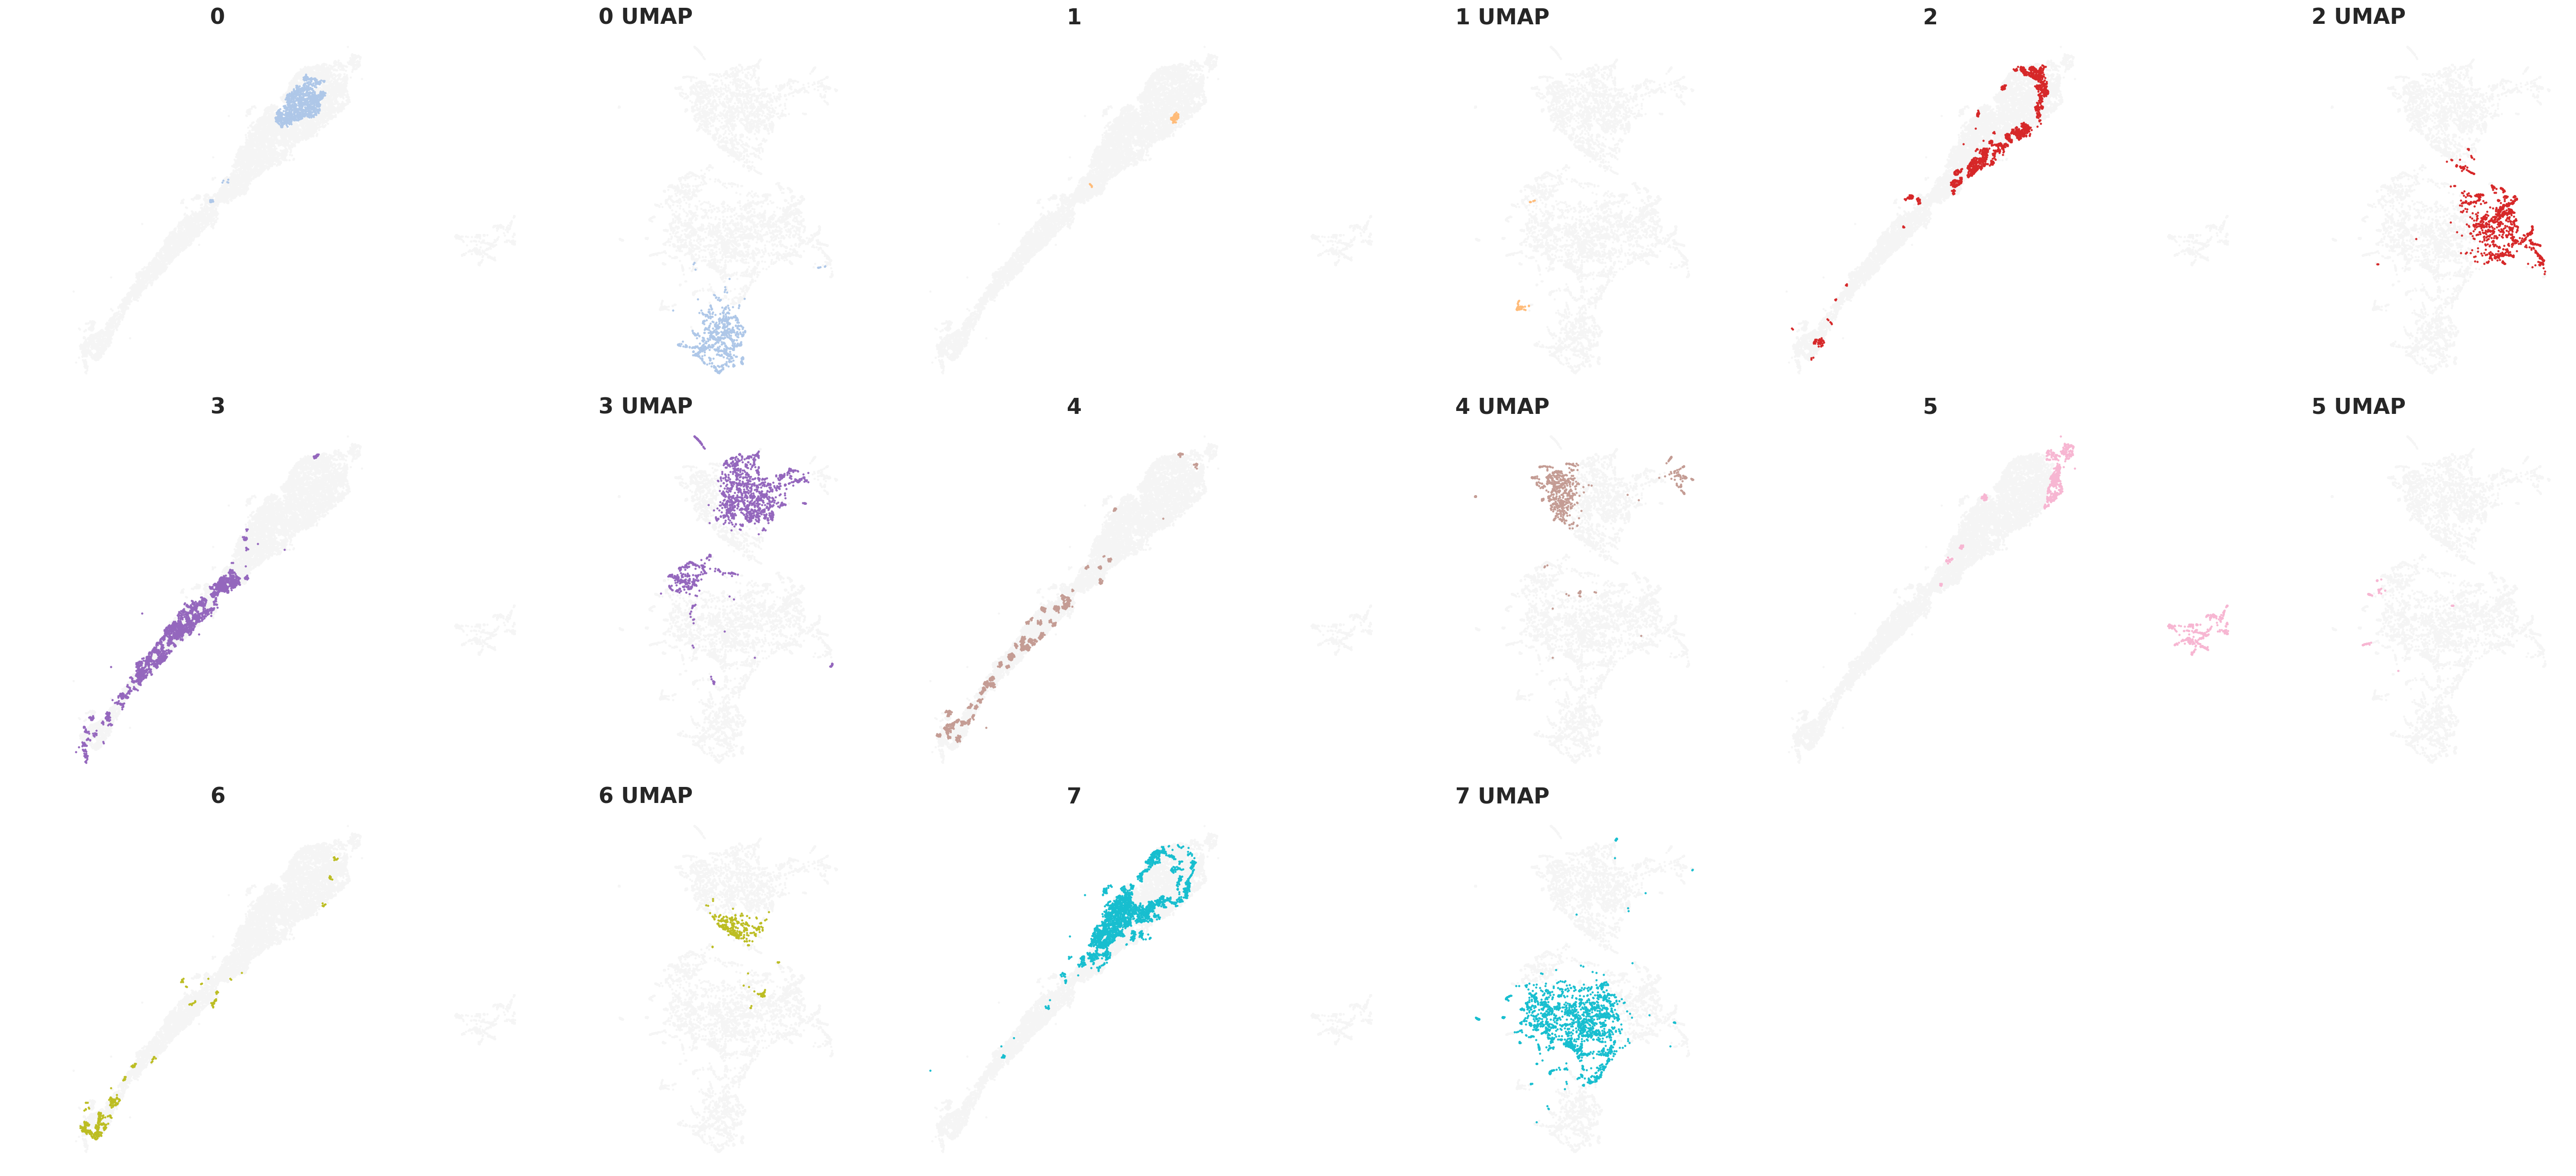

In [20]:
from banksy.plot_banksy import plot_results

c_map =  'tab20' # specify color map
weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]

plot_results(
    results_df,
    weights_graph,
    c_map,
    match_labels = True,
    coord_keys = coord_keys,
    max_num_labels  =  max_num_labels, 
    save_path = os.path.join(file_path, 'tmp_png'),
    save_fig = True, # save the spatial map of all clusters
    save_seperate_fig = True, # save the figure of all clusters plotted seperately
    dataset_name = "ck_skin_res"
)

### (Data Analysis) Analyzing Results from BANKSY

We manually annotate the cluster layers generated by BANKSY and analyze its generated clusters. <br> However, note that the clusters may differ slightly between versions of different modules due to the randomness in the leiden partition. The annotations below are exclusive to the analysis obtained from our environnment only.

In [ ]:
# from banksy_utils.cluster_utils import pad_clusters, create_spatial_nonspatial_adata,  refine_cell_types

# # Here we manually assign clusters to their identity using a dictionary
# cluster2annotation_spatial = {
#     "0" : "Granular Layer",
#     "2" : "Purkinje/Bergmann",
#     "3" : "Molecular layer interneurons",
#     "4" : "Oligodendrocyte/Polydendrocyte",
#     "5" : "RBC",
# }

# pad_clusters(cluster2annotation_spatial, list(range(max_num_labels)))

In [ ]:
# # Here, most clusters match so copy labels from spatial
# # cluster2annotation_nonspatial = cluster2annotation_spatial.copy()
# # cluster2annotation_nonspatial["4"] = "Purkinje/Bergmann"
# # cluster2annotation_nonspatial["8"] = "other"
# # cluster2annotation_nonspatial["11"] = "Choroid Plexus"
# # cluster2annotation_nonspatial["15"] = "other"

# cluster2annotation_nonspatial = {
#     "0" : "Granular Layer",
#     "2" : "Purkinje/Bergmann",
#     "3" : "Molecular layer interneurons",
#     "4" : "Oligodendrocyte/Polydendrocyte",
#     "5" : "RBC",
# }

# print(cluster2annotation_spatial,"\n", cluster2annotation_nonspatial)

# # save annotations in two different anndata objects (adata_spatial and adata_nonspatial)

# adata_spatial, adata_nonspatial = create_spatial_nonspatial_adata(results_df,
#                                     pca_dims,
#                                     lambda_list, 
#                                     resolutions,
#                                     cluster2annotation_spatial,
#                                     cluster2annotation_nonspatial)

### DE analysis of self genes (only) from BANKSY clustering

combine 2 Granular layer clusters, merge all unknown clusters

In [ ]:
# from banksy_utils.plot_utils import plot_DE_genes, plot_DE_genes_refined, plot_connection_grid, plot_clusters

# cluster2annotation_refine = {
#     "RBC" : "other",
# }

# adata_spatial_filtered, adata_nonspatial_filtered = refine_cell_types(adata_spatial, 
#                                                                       adata_nonspatial,
#                                                                       cluster2annotation_refine
#                                                                       )

In [ ]:
adata_self = plot_DE_genes_refined(adata_spatial_filtered, plot_heatmap = False, save_fig = False)

### Show connection grid

Show heatmap representing how intermingled each cluster is with each other cluster. Arrange clusters (each corresponding to a cell type) in order of layers of the cerebellum, from MLI to Oligo.

In [ ]:
# cell_types = ["Molecular layer interneurons", 
#               "Purkinje/Bergmann", 
#               "Granular Layer",
#               "Oligodendrocyte/Polydendrocyte",]

# plot_connection_grid(
#     banksy_dict["scaled_gaussian"]["weights"][0].copy(),
#     adata_nonspatial,
#     adata_spatial,
#     cell_types= cell_types,
#     save_fig=False
# )

compare **spatial map** of selected clusters side by side:

In [ ]:
# # choose colours for each cluster
# colors_dict = {
#     "Granular Layer": "tab:blue",
#     "Molecular layer interneurons": "tab:orange",
#     "Purkinje/Bergmann": "tab:red",
#     "Oligodendrocyte/Polydendrocyte": "tab:green",
# }

# plot_clusters(
#     adata_spatial,
#     adata_nonspatial,
#     colors_dict,
# )

## Plot DE genes of clusters from scRNAseq reference atlas
Note this requires the RCTD weights from the dropviz.org webpage

In [ ]:
# # display(adata_allgenes)
# print_max_min(adata_allgenes)

# # z-score the unfiltered gene-cell matrix
# # ---------------------------------------
# sc.pp.scale(adata_allgenes)
# # display(adata_allgenes)
# print_max_min(adata_allgenes)

### Get scRNA-seq reference marker genes and compute metagene

Marker genes are obtained from reference scRNA-seq dataset available at **dropviz.org**. 

DE genes are compared against rest of cerebellum with parameters (*default*):
 - Minimum Fold Ratio = 2
 - Minimum P-Value Exponent = -100
 - Min Mean Log Amount in Target = 2.5
 - Max Mean Log amount in Comp = 1
 
Marker genes filtered out in preprocessing are not included.

In [ ]:
# # Metagene Dataframe
# from banksy_utils.cluster_utils import create_metagene_df

# metagene_df = create_metagene_df(adata_allgenes, coord_keys)
# metagene_df.head()

In [ ]:
# from banksy_utils.plot_utils import plot_markergene_sets

# # load weights and locations (need to load locations because filtered seperately)
# rctd_coord_filename = "slideseqv1_mc_coords_filtered.csv"
# rctd_weights_filename = "slideseqv1_mc_RCTDweights.txt"
# rctd_coord = pd.read_csv(os.path.join(file_path, rctd_coord_filename), index_col=0)
# rctd_weights = mmread(os.path.join(file_path, rctd_weights_filename)).todense()

# plot_markergene_sets(metagene_df,
#                      rctd_coord,
#                      rctd_weights,
#                      coord_keys,
#                      save_fig=False)

### Comparison between spatial, nonspatial and RCTD weights

In [ ]:
# from banksy_utils.plot_utils import plot_weights_comparsion

# # We use the layers args to indicate which layers to plot
# # Here the layers are [nonspatial, spatial, RCTD, marker-genes]
# layers1 = [
#     [("Granular Layer", "Granular Layer"), 
#      ("Granular Layer", "Granular Layer"),
#      ("GranularNeuron_Gabra6",), 
#      ("GranularNeuron_Gabra6",)
#     ],
# ]

# plot_weights_comparsion(
#     adata_spatial,
#     adata_nonspatial,
#     adata_allgenes,
#     layers1,
#     colors_dict,
#     rctd_coord=rctd_coord,
#     rctd_weights=rctd_weights,
#     save_fig=False,
#     file_path=file_path,
#     save_png_name="subplots_layers_sseqcerebellum_v1.png"
# )

**Note:** Figure in paper was generated using older version of scanpy, where the MLI and Purkinje layer were merged into a single cluster.
Non-spatial finds more clusters this version (latest versions of Scanpy and other packages), but is still much less accurate than BANKSY

In [ ]:
# layers2 = [
#     [("Purkinje/Bergmann",), 
#      ("Purkinje/Bergmann",), 
#      ("PurkinjeNeuron_Pcp2",),
#      ("PurkinjeNeuron_Pcp2",),
#     ],
#     [("Molecular layer interneurons",),
#      ("Molecular layer interneurons",), 
#      ("Interneurons_Pvalb",),
#      ("Interneurons_Pvalb",)
#     ],
#     [("Oligodendrocyte/Polydendrocyte"),
#      ("Oligodendrocyte/Polydendrocyte"), 
#      ("Oligodendrocyte_Polydendrocyte_Tfr_Tnr",),
#      ("Oligodendrocyte_Polydendrocyte_Tfr_Tnr",)
#     ],
# ]

# plot_weights_comparsion(
#     adata_spatial,
#     adata_nonspatial,
#     adata_allgenes,
#     layers2,
#     colors_dict,
#     rctd_coord=rctd_coord,
#     rctd_weights=rctd_weights,
#     save_fig=False,
#     file_path=file_path,
#     save_png_name="subplots_layers_sseqcerebellum_v1.png"
# )